# **Machine Learning Reconstruction of Surface Ocean pCO₂**
Spring 2025, EESC4243/STAT4243/5243 “Climate Prediction Challenges with Machine Learning”, Columbia University

## Introduction 
The ocean plays a crucial role in the global carbon cycle by absorbing atmospheric CO₂, having absorbed 38% of all anthropogenic fossil fuel emissions over the industrial era. 

Accurate estimation of air–sea CO₂ flux is critical for understanding the current and future global carbon budget, yet remains challenging due to the sparse and unevenly distributed nature of surface ocean pCO₂ observations. The **Surface Ocean CO₂ Atlas (SOCAT)** database (https://socat.info/) provides the most extensive dataset available, but its coverage is limited to only about 2% of all boxes of 1 degree X 1 degree (= 100km X 100km at the equator) over the last several decades. Data are particularly limited in high-latitude regions and during winter months.

To fill in the gaps in these data, statistical and machine learning (ML) techniques have been widely used to reconstruct global pCO₂ fields by interpolating between observations using environmental predictors such as sea surface temperature (SST), sea surface salinity (SSS), mixed layer depth (MLD), chlorophyll-a (Chl-a), and atmospheric CO₂ (xCO₂).

How good are these methods? Since the real full-coverage pCO2 of the ocean is unknown, we need another approach to assess the skill of ML-based reconstructions. Our answer is the **Large Ensemble Testbed (LET)**, which provides full-coverage pCO₂ output from Earth System Models, as well as associated driver varibles also from the ESM. In the context of this testbed, we can sample the pCO2 in the same pattern as real-world SOCAT and then reconstruct. Since the full-field pCO2 field is known ("Model Truth"), we can directly evaluate of ML reconstruction performance. With this approach, it has been shown that ML methods can capture seasonal variability well, they often overestimate decadal variability, particularly in regions with limited data coverage (Gloege et al. 2021).

This study builds upon previous work by incorporating a **pCO₂-Residual** approach to improve ML-based pCO₂ reconstructions. The **pCO₂-Residual** method removes the temperature-driven component from pCO₂ before applying ML, thereby reducing the dominance of temperature in predictions and enhancing the ability of the model to capture non-temperature-driven variability. 


We reproduce a portion of the analysis carried out by  
**Gloege et al. (2021)** *"Quantifying Errors in Observationally Based Estimates of Ocean Carbon Sink Variability."* **Global Biogeochemical Cycles** 34: e2020GB006788.  
([DOI: 10.1029/2020GB006788](https://doi.org/10.1029/2020GB006788))  

using the method of  
**Bennington et al. (2022)** *"Explicit Physical Knowledge in Machine Learning for Ocean Carbon Flux Reconstruction: The pCO2-Residual Method"*. **Journal of Advances in Modeling Earth Systems**, 14(10). ([DOI: 10.1029/2021ms002960](https://doi.org/10.1029/2021ms002960))

Our study:
1. Implements an **XGBoost-based pCO₂-Residual reconstruction**  (Bennington et al. 2022).
2. Evaluates reconstruction performance using a Large Ensemble Testbed, with **bias and correlation metrics** as in Gloege et al (2021).


### Running Notes
1. Users need to enter their GitHub/LEAP-Pangeo username at the end of Section 2.
2. Several time-consuming steps have outputs saved to files, so they only need to be run initially or if changes are made:  
    - Section 4.3: ML Training (~1 minute/ESM member)  
    - Section 4.4: Reconstruction/Inference (~1 minute/ESM member)  
    - Section 4.4.1: Summation of pCO2-Residual and pCO2-T to recover pCO2 (~15 seconds/ESM member)


    With a **128GB CPU**, actual runtimes may vary based on system load and selected members, but this serves as a general guideline.


## Important Controls:  
- **your_username**: The username of the person running the code.  
- **owner_username**: The username of the notebook owner.  
- **runthiscell**: Default = 1.  
  - **Disable a cell by setting `runthiscell=0`**.  
  - **Reviewers should set `runthiscell=-1` to save time and space**.  

### Instructions:  
- **If you're running your own code**:  
  - 'your_username' should be the same as 'owner_username' (both should be your account name).  
  - Disable a cell by setting 'runthiscell=0'.  

- **If you're a reviewer**:  
  - Set `your_username` to your own name while keeping `owner_username` as the notebook owner's name.  
  - Set `runthiscell=-1`.  
  - Run only the first member of the first ESM and load ML results for the other members from the owner's saved bucket file.

In [1]:
your_username = 'mc5601'  # username of the person running the code. Reviewers should also change this to their own username.

#To allow the reviewer to access the saved files, provide notebook owner's username here:  
owner_username = ''  # Reviewer should not change this name

## Overview of the Large Ensemble Testbed Approach

This figure (Figure 1 of Gloege et al. 2021) illustrates the main steps in the pCO₂ reconstruction workflow using the Large Ensemble Testbed. 
Panel A shows the sampling, training, and reconstruction process, while panel B breaks down the reconstructed 
CO₂ flux into different temporal components for evaluation. 

In this project, we take a similar approach, but we remove the complication of the calculation of CO₂ flux from pCO₂. Results can be expected to be qualitatively the same. 


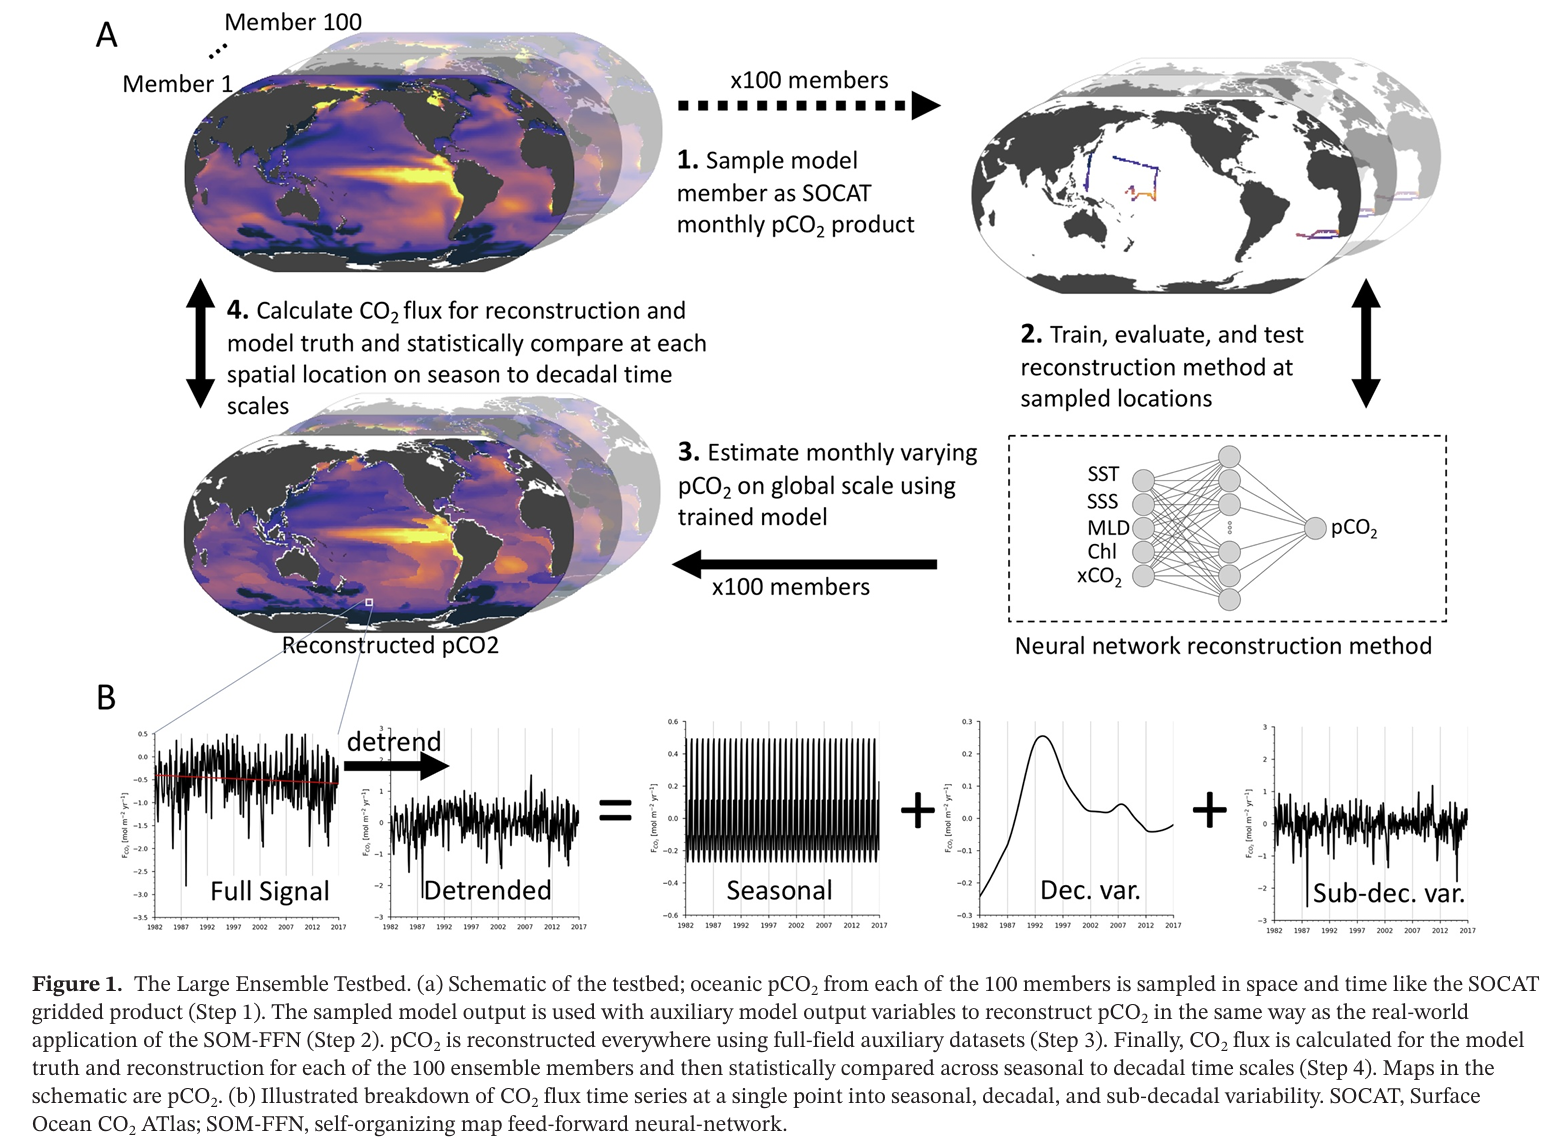

In [2]:
from IPython.display import Image
Image(filename="../images/figure1.png", width=1000)

# 0. Setup Workspace and Import Packages
We use %%capture to suppress output and keep the notebook clean. However, feel free to remove it if you want to check warnings or logs.


In [3]:
%%capture
!pip install tensorflow
!pip install keras

In [4]:
import os
os.getcwd()


'/home/jovyan/Project_3_fork/Project-StarterCodes/Project3-ReconstructPCO2/notebooks'

In [5]:
import os
os.chdir('../notebooks/')


In [6]:
!pwd

/home/jovyan/Project_3_fork/Project-StarterCodes/Project3-ReconstructPCO2/notebooks


In [7]:
%%capture
### standard imports ###
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
import fsspec
### Python file with supporting functions ###
# standard imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
# Redirect all low-level stderr output
sys.stderr = open(os.devnull, 'w')

import datetime
from collections import defaultdict
import random
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth',100)
import csv
import cmocean as cm

# machine learning libraries
import xgboost as xgb     
from xgboost import XGBRegressor

# Change to the parent directory of the current working directory. (Run only once—otherwise it will keep moving up the directory tree)
os.chdir(os.path.dirname(os.getcwd()))
print("Current working directory:", os.getcwd())

# Python file with supporting functions
import lib.residual_utils as supporting_functions
from lib.visualization import *
from lib.bias_figure2 import concat_datasets, XarrayEvaluator
from lib.corr_figure3 import eval_spatial


E0000 00:00:1745940435.639193      74 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745940435.643913      74 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745940435.656439      74 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745940435.656467      74 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745940435.656469      74 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745940435.656470      74 computation_placer.cc:177] computation placer already registered. Please check linka

In [8]:
### Setting the date range to unify the date type ###

# Define date range
date_range_start = '2004-01-01T00:00:00.000000000'
date_range_end = '2023-12-31T00:00:00.000000000'

# create date vector, adds 14 days to start & end
dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS')


init_date = str(dates[0].year) + format(dates[0].month,'02d')
fin_date = str(dates[-1].year) + format(dates[-1].month,'02d')

# 1. Surface ocean pCO2: A sparse data challenge

Here, we visualize all SOCAT data for the period selected for this analysis (default is 2004-2023). 

We plot the total number of months of available data at each 1 degree X 1 degree location (100x100km at the equator). 

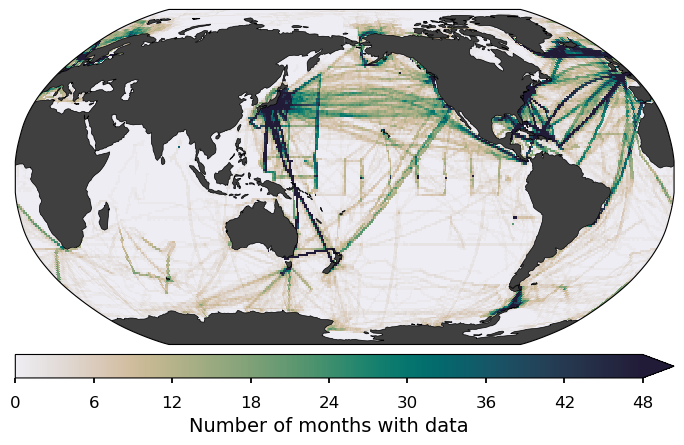

In [9]:
# 1. Surface ocean pCO2: A sparse data challenge
zarr_dir = 'gs://leap-persistent/abbysh/zarr_files_'
socat_path = f"{zarr_dir}/socat_mask_feb1982-dec2023.zarr"
# Updated loading approach
socat_mask_data =  xr.open_zarr(socat_path).sel(time=slice(str(dates[0]),str(dates[-1])))

non_zero_counts = (socat_mask_data.socat_mask != 0).sum(dim="time")
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                   cbar_mode='each',
                   colorbar=True,
                   cbar_location='bottom',
                   nrows_ncols=[1,1])
    
    vrange = [0, 48, 6]
    cmap = cm.cm.rain
    data = xr_add_cyclic_point(non_zero_counts, cyclic_coord='xlon')
    data = data.assign_coords(xlon=(((data.xlon + 180) % 360) ))
    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                      vrange=vrange[0:2], cmap=cmap, ax=0, linewidth_coast=0.5)
    
    col = worldmap.add_colorbar(sub, ax=0,extend='max')
    worldmap.set_cbar_xlabel(col, 'Number of months with data', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    plt.show()

In [10]:
# =========================================================
# Override socat_mask with EXTENDED SOCAT mask
# =========================================================
# Compute original mask boolean array
original_mask = (socat_mask_data.socat_mask != 0)

# Create southern latitude mask (latitudes south of 45°S)
southern_lat = (socat_mask_data.coords['ylat'] < -45)
southern_mask_3d = southern_lat.broadcast_like(original_mask)

# Combine to form extended mask
socat_mask_extended = xr.where(original_mask | southern_mask_3d, 1, 0)

# Alias extended mask to socat_mask for downstream use
socat_mask = socat_mask_extended
print("socat_mask now points to the extended mask")

socat_mask now points to the extended mask


SOCAT data coverage is uneven, with some regions, particularly in the Southern Hemisphere and open ocean areas, having significantly fewer observations. Regions with denser observational coverage, such as the Northern Hemisphere, tend to have lower biases in CO2 flux reconstructions compared to sparsely sampled areas like the Southern Ocean.

# 2. Data Introduction and Storage

## **2.1 Input (Features) Sources**
The **input features** for the machine learning model are derived from **pre-processed Earth System Model (ESM) outputs or inputs**

### **Feature and Target Variables for the ML Model**
The features used for training the **pCO₂-Residual machine learning model** are listed below:


| **Feature** | **Description** | **ESM Input or Output?** | 
|------------|----------------|----------------|
| **SST (Sea Surface Temperature)** | Simulated ocean surface temperature | **ESM Output** |  
| **SST_anom** | SST anomaly from climatology | **ESM Output** |  
| **SSS (Sea Surface Salinity)** | Simulated surface ocean salinity | **ESM Output** |  
| **SSS_anom** | SSS anomaly from climatology | **ESM Output** |  
| **MLD_clim_log** | Log-transformed climatological mixed layer depth | **ESM Output** |  
| **Chl-a (Chlorophyll concentration)** | Proxy for biological activity (log-transformed) | **ESM Output** |  
| **Chl-a_anom** | Anomaly of Chl-a | **ESM Output** |  
| **xCO₂ (Atmospheric CO₂ concentration)** | Atmospheric CO₂ mole fraction | **ESM Input, from data** |  
| **A, B, C** | Space on the globe | **See Bennington et al. 2022, Table 1** |  
| **T0, T1** | Time | **See Bennington et al. 2022, Table 1** |  


The **target variable** for reconstruction is:
- **pCO₂-Residual**: This deviation from the temperature-driven component of pCO₂, reducing SST's dominance in ML reconstructions and improving model performance in data-sparse regions (detailed below).

### **Data Sources and Paths**
The data is stored in a **cloud environment, LEAP-Pangeo**, ensuring efficient access and scalability for the machine learning workflow. Key datasets include:

- **Ensemble dir**:

  Contains the original data from pre-processed Earth System Model (ESM) outputs, available for 100+ ESM members. For computational efficiency, we rely on a selection of this dataset compiled by TA Xinyi Ke. The full ensemble data is available and could be explored, with due consideration of storage constraints. 
  
- **ML Input and Target Data**:

    Provides a dataframe-format dataset containing preprocessed ML inputs and ground truth from a selected subset of ensemble members. You may also generate your own dataset for a custom selection or range of members (see reference: Project3_Data.ipynb). Due to limited GCS storage, we recommend using the provided dataset for most projects.
  
- **SOCAT Data (Mask File)**:  

  Masking file based on real-world **SOCAT pCO₂ observations**. Here, these data are not used directly, but are input solely so that their sampling pattern in space and time can be applied to model pCO2 fields, thus mimicing real-world observational density.

### **Key Considerations:**
- **pCO₂-Residual**: By removing the temperature-driven component from pCO₂, we enhance the ability of machine learning models to capture **non-temperature-driven variability**, particularly in poorly observed regions.
- **Data Subsampling Based on SOCAT**: The use of a **SOCAT-derived mask** ensures that the ML model is trained and evaluated using a realistic observational distribution, mitigating potential biases from uneven data coverage.

### **Final Input Structure**:
- **Feature Matrix**: `(N, 12)`, where `N` represents the number of samples, and 12 predictor variables are used.
- **Target Variable**: `pCO₂-Residual`, which the model aims to reconstruct.


In [11]:
# features for ML:
features_sel = ['sst','sst_anom','sss','sss_anom','mld_clim_log','chl_log','chl_log_anom','xco2','A', 'B', 'C', 'T0', 'T1']

# the target variable we reconstruct:
target_sel = ['pco2_residual'] # this represents pCO2 - pCO2-T (calculated in notebook 00)

 **Compute the temperature-driven component** of pCO₂:

$$
\text{pCO}_{2,T} = \overline{\text{pCO}_2} \cdot \exp\left[ 0.0423 \cdot (T - \overline{T}) \right]
$$

- $ \overline{\text{pCO}_2} $: long-term mean of surface ocean pCO₂  
- $ T $: sea surface temperature at a given time/location  
- $ \overline{T} $: long-term mean sea surface temperature  
- $ 0.0423 $: empirically derived constant (from Takahashi et al., 1993)


 **Subtract to get the residual**:

$$
\text{pCO}_{2,\text{Residual}} = \text{pCO}_2 - \text{pCO}_{2,T}
$$

This residual is then used as the **target variable** in ML training, helping disentangle the direct solubility-driven temperature effect from other biogeochemical processes.

In our workflow, this calculation was done during processing of the Earth System Model (ESM) dataset, not included in this notebook. The datasets under `ensemble_dir` include the variable `pCO2_T`. For this notebook, we will directly use the preprocessed ML input dataset, which includes `pco2_residual`.

Later in the notebook, we recover the total pCO2 by **adding the temperature component back** to the residual:

$$
\text{pCO}_2 = \text{pCO}_{2,\text{Residual}} + \text{pCO}_{2,T}
$$


In [12]:
### set up for getting files from leap bucket ###
fs = gcsfs.GCSFileSystem()

### paths for loading: ###
# directory of regridded members from notebook 00
ensemble_dir = "gs://leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members" # path to regridded data
path_seeds = "gs://leap-persistent/abbysh/pickles/random_seeds.npy" # random seeds for ML

# directory of reference zarr files
zarr_dir = 'gs://leap-persistent/abbysh/zarr_files_'

# socat data file
socat_path = f"{zarr_dir}/socat_mask_feb1982-dec2023.zarr"

# preprocessed ESM ensemble members
MLinputs_path = "gs://leap-persistent/Mukkke/pco2_residual/post01_xgb_inputs_parquet"



### **Output Data Storage and Model Saving**

The output data generated by this notebook, including model predictions, performance metrics, and trained models, is saved in a cloud-based environment using a user-specific directory structure. This ensures that each user’s results are organized and accessible without interfering with others’ work.

The output data is organized into three main categories:  
1. **Machine Learning Models:** Trained models are saved for future use, ensuring that results can be replicated without re-training.  
2. **Reconstructions:** Predicted pCO₂ fields are stored for further analysis and visualization.  
3. **Performance Metrics:** CSV files containing test and unseen data performance metrics are saved for easy evaluation.


### Users must enter their Github/LEAP-Pangeo username in the cell below

In [13]:
grid_search_approach = 'nmse'
output_dir = f'gs://leap-persistent/{your_username}/{owner_username}/pco2_residual/{grid_search_approach}/post02_xgb' # where to save machine learning results

model_output_dir = f"{output_dir}/trained" # where to save ML models
recon_output_dir = f"{output_dir}/reconstructions" # where to save ML reconstructions
recon_output_dir_extlag = f"{output_dir}/reconstructions_extlag"

metrics_output_dir = f'{output_dir}/metrics' # where to save performance metrics
test_perform_fname = f"{metrics_output_dir}/xgb_test_performance_{init_date}-{fin_date}.csv" # path for test performance metrics
unseen_perform_fname = f"{metrics_output_dir}/xgb_unseen_performance_{init_date}-{fin_date}.csv" # path for unseen performance metrics

xgb_model_save_dir = f'{output_dir}/saved_models_{init_date}-{fin_date}' # where to save .json model file
xgb_model_local_save_dir = "output/model_saved"


# 3.  Earth System Models and their Ensemble Members
This notebook utilizes data from multiple Earth System Models (ESMs) that are part of the **Large Ensemble Testbed (LET)**. The LET originally includes **100 ensemble members** from different ESM, each representing unique initial conditions. These ensemble members are crucial for capturing internal climate variability and assessing model uncertainty.  

However, to optimize computational efficiency and simplify machine learning workflows, we select some representative member from the three ESM. If desired, you can modify the `mems_dict` variable to include more members from each ESM. This flexibility allows for expanded analyses while maintaining the structure of this notebook.


In [14]:
mems_dict = dict()

# Get all paths
all_paths = fs.ls(MLinputs_path)

for ens_path in all_paths:             
    ens = ens_path.split('/')[-1]
    mems = fs.ls(ens_path)
    for mem in mems:        
        memo = mem.split('/')[-1]
        if ens not in mems_dict:
            mems_dict[ens] = [memo]
        elif ens in mems_dict:
            mems_dict[ens].append(memo)


In [15]:
mems_dict

{'ACCESS-ESM1-5': ['member_r10i1p1f1',
  'member_r1i1p1f1',
  'member_r2i1p1f1',
  'member_r31i1p1f1',
  'member_r5i1p1f1'],
 'CanESM5': ['member_r1i1p1f1',
  'member_r1i1p2f1',
  'member_r2i1p1f1',
  'member_r3i1p2f1',
  'member_r6i1p2f1'],
 'MPI-ESM1-2-LR': ['member_r11i1p1f1',
  'member_r12i1p1f1',
  'member_r15i1p1f1',
  'member_r22i1p1f1',
  'member_r23i1p1f1'],
 'UKESM1-0-LL': ['member_r1i1p1f2',
  'member_r2i1p1f2',
  'member_r3i1p1f2',
  'member_r4i1p1f2',
  'member_r8i1p1f2']}


**Note:**  
The `ensemble_dir` contains a large collection of ESM outputs. We’ve already preprocessed data for **four ESMs**, each with **five members**, and saved them in the `MLinputs_path` directory for convenience.

In the starter notebook, we select only **3 ESMs** and **3 members per model** (see next cell) to reduce storage and computation. If you'd like to explore additional models or members, we recommend starting with the remaining preprocessed data available under `MLinputs_path`.

If you wish to go further and access additional members or ESMs from `ensemble_dir`, please refer to `Project3_Data.ipynb` for instructions on how to retrieve and preprocess the raw data into ML-ready DataFrames.

---
> **Storage:** Each student has a 25GB storage limit in your home directory. Please avoid stay within the quota. Each preprocessed DataFrame (covering data from 2004-01-01 to 2023-12-31) is approximately **2.35 GB**. Intermediate files are also needed.

> **/leap-persistent:** Instead of relying on home directories, we use the shared /leap-persistent/ bucket, which is a larger shared resource with common access permissions. Though there is not a quoata, please be a good citizen and avoid keeping lots of files you do not need. See the notebook "files_leappersistent_management.ipynb" with code needed to manage your files. 

> **Sharing from /leap-persistent:**  Groups can share files seamlessly with the /leap-persistent/ bucket. Consider this approach for your group. 

---

In [16]:
## Here you can change which models and how many members you use
random.seed(42)  # Set seed for reproducibility

selected_ensembles = ['ACCESS-ESM1-5', 'CanESM5', 'MPI-ESM1-2-LR']
selected_members_dict = {esm: mems_dict[esm] for esm in selected_ensembles}

selected_mems_dict = {}
num_members = 3  # Set the number of ensemble members from each ESM

for ens, members in selected_members_dict.items():
    if len(members) >= num_members:
        selected_mems_dict[ens] = random.sample(members, num_members)  # Select `num_members` random members
    else:
        selected_mems_dict[ens] = members  # If there are fewer members than `num_members`, select all

print(selected_mems_dict)

{'ACCESS-ESM1-5': ['member_r10i1p1f1', 'member_r5i1p1f1', 'member_r2i1p1f1'], 'CanESM5': ['member_r2i1p1f1', 'member_r1i1p2f1', 'member_r1i1p1f1'], 'MPI-ESM1-2-LR': ['member_r12i1p1f1', 'member_r11i1p1f1', 'member_r15i1p1f1']}


To better understand how the data is organized in GCS, we can use the following command to list all files under a specific path. In this example, we check the dataset for the ESM 'ACCESS-ESM1-5' and its first member (index 0):

In [17]:
fs = gcsfs.GCSFileSystem()
ens0 = 'ACCESS-ESM1-5'
member_dir = f"{ensemble_dir}/{ens0}/{selected_mems_dict[ens0][0]}"
files = fs.ls(member_dir)

print("Files in GCS directory:")
for file in files:
    print(file)


Files in GCS directory:
leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r10i1p1f1/ACCESS-ESM1-5.r10i1p1f1.Omon.zarr
leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r10i1p1f1/chlclim_ACCESS-ESM1-5.r10i1p1f1.Omon.zarr


Similarly, to loop through all selected ESMs and their members, we can use the following code. This allows us to check the directory and filename for each ensemble-member combination:

In [18]:
for ens, mem_list in selected_mems_dict.items():
    for member in mem_list:
        print(ens, member)
        data_dir = f"{MLinputs_path}/{ens}/{member}"
        files = fs.ls(data_dir)
        for file in files:
            print(file)

ACCESS-ESM1-5 member_r10i1p1f1
leap-persistent/Mukkke/pco2_residual/post01_xgb_inputs_parquet/ACCESS-ESM1-5/member_r10i1p1f1/MLinput_ACCESS-ESM1-5_r10i1p1f1_mon_1x1_200401_202312.parquet
ACCESS-ESM1-5 member_r5i1p1f1
leap-persistent/Mukkke/pco2_residual/post01_xgb_inputs_parquet/ACCESS-ESM1-5/member_r5i1p1f1/MLinput_ACCESS-ESM1-5_r5i1p1f1_mon_1x1_200401_202312.parquet
ACCESS-ESM1-5 member_r2i1p1f1
leap-persistent/Mukkke/pco2_residual/post01_xgb_inputs_parquet/ACCESS-ESM1-5/member_r2i1p1f1/MLinput_ACCESS-ESM1-5_r2i1p1f1_mon_1x1_200401_202312.parquet
CanESM5 member_r2i1p1f1
leap-persistent/Mukkke/pco2_residual/post01_xgb_inputs_parquet/CanESM5/member_r2i1p1f1/MLinput_CanESM5_r2i1p1f1_mon_1x1_200401_202312.parquet
CanESM5 member_r1i1p2f1
leap-persistent/Mukkke/pco2_residual/post01_xgb_inputs_parquet/CanESM5/member_r1i1p2f1/MLinput_CanESM5_r1i1p2f1_mon_1x1_200401_202312.parquet
CanESM5 member_r1i1p1f1
leap-persistent/Mukkke/pco2_residual/post01_xgb_inputs_parquet/CanESM5/member_r1i1p1f1/ML

Unlike the sparse observational data, Earth System Model (ESM) outputs provide continuous global coverage of climate variables. To better understand the observational constraints, we apply a SOCAT-based mask to the ESM data. This mask mimics the data sparsity of real-world observations by selectively masking regions where SOCAT observations are absent. The SOCAT mask varies over time, reflecting the temporal evolution of observational coverage.

Using this mask, we process all ESM data to generate a sparse dataset that requires reconstruction, where the unmasked regions serve as the ground truth for evaluating reconstruction accuracy.

In this figure, we visualize the pCO₂ field from a selected ensemble member of an ESM for a specific time period, applying the SOCAT mask to illustrate how the data coverage changes.

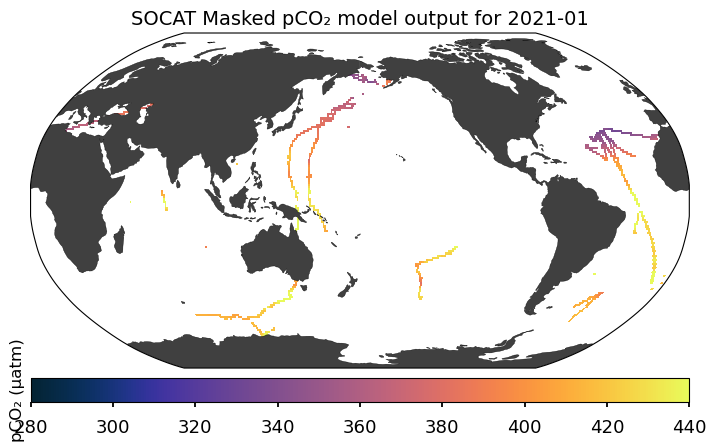

In [19]:
first_ens = list(selected_mems_dict.keys())[0]
first_mem = selected_mems_dict[first_ens][0]

member_dir = f"{ensemble_dir}/{first_ens}/{first_mem}"
member_path = fs.glob(f"{member_dir}/*.zarr")[0]
# member_data = xr.open_mfdataset('gs://'+member_path, engine='zarr').sel(time=slice(str(dates[0]),str(dates[-1])))
member_data = xr.open_zarr('gs://'+member_path).sel(time=slice(str(dates[0]),str(dates[-1])))

plot_style = "seaborn-v0_8-talk"

cmap = cm.cm.thermal
cbar_title = 'pCO₂ (µatm)'
vrange = [280, 440]  # Ensure correct range format

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) 
    worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='each',
                           colorbar=True,  # Enable colorbar
                           cbar_location='bottom',
                           nrows_ncols=[1,1])
    
    chosen_time = '2021-01'
    data = member_data["spco2"].sel(time=chosen_time).squeeze()
    data = xr_add_cyclic_point(data, cyclic_coord='xlon')    
    mask = socat_mask_data.sel(time=chosen_time)["socat_mask"].squeeze()
    mask = xr_add_cyclic_point(mask, cyclic_coord='xlon')    
    masked_data = np.ma.masked_array(data, mask=(mask == 0))  # Mask where mask==0

    data = data.assign_coords(xlon=(((data.xlon + 180) % 360) - 180))
    mask = mask.assign_coords(xlon=(((mask.xlon + 180) % 360) - 180))

    sub = worldmap.add_plot(lon=data['xlon'], 
                            lat=data['ylat'], 
                            data=masked_data,
                            vrange=vrange,  # Corrected vrange
                            cmap=cmap, 
                            ax=0)

    # Add colorbar properly
    colorbar = worldmap.add_colorbar(sub, ax=0)
    worldmap.set_cbar_ylabel(colorbar, cbar_title, fontsize=12)

    # Add title
    worldmap.set_title("SOCAT Masked pCO₂ model output for 2021-01", ax=0, fontsize=14)

    plt.show()


We can adjust the values of chosen_time and mmeber to explore different available data, which helps us better understand the masked ESM data that will be used in the following machine learning work.

# 4. ML Reconstruction

## 4.1 Data Split

We split data to training data set and testing dataset based on date.

In [20]:
### train-validate-test split proportions ###

select_dates = []
test_dates = []

for i in range(0,len(dates)):
    if i % 5 != 0:
        select_dates.append(dates[i]) ### 80% train days set ###
    if i % 5 == 0:
        test_dates.append(dates[i]) ### 20% test days set ### 

### Then, the month numbers above are converted back to their respective datetime objects.

year_mon = []

for i in range(0,len(select_dates)):
    
    tmp = select_dates[i]
    year_mon.append(f"{tmp.year}-{tmp.month}")
    
test_year_mon = []

for i in range(0,len(test_dates)):
    
    tmp = test_dates[i]
    test_year_mon.append(f"{tmp.year}-{tmp.month}")

## 4.2 Hyperparameters

In [21]:
params = {
    'n_estimators': 500,  # Number of boosting rounds
    'max_depth': 6,  # Maximum depth of each tree to control model complexity
    'learning_rate': 0.05,  # Step size shrinkage to prevent overfitting
    'subsample': 0.8,  # Fraction of samples used for training each tree
    'colsample_bytree': 0.8,  # Fraction of features used per tree
    'gamma': 0.1,  # Minimum loss reduction required for further partitioning
    'min_child_weight': 5,  # Minimum sum of instance weight in a leaf node
    'reg_alpha': 0.1,  # L1 regularization to reduce model complexity
    'reg_lambda': 1.0,  # L2 regularization for preventing overfitting
    'objective': 'reg:squarederror',  # Loss function for regression tasks
    'n_jobs': 30,  # Number of parallel threads to use for training
    'eval_metric': 'rmse',
    'early_stopping_rounds': 50  # Stop training if performance doesn't improve for 50 rounds
}

### Important Note: Run ML (4.3) and Reconstruction (4.4) Part Only Once

The **ML Reconstruction** step needs to be run **only once** for each ML model developed. This helps save computational resources and execution time.

The reconstruction data is saved under our **own username-specific workspace** in GCS. This means that even if you exit and re-enter JupyterHub, your data will remain available, eliminating the need for reprocessing.

### Before Running Again:
Before re-running the ML training steps, make sure a new experiment is actually necessary. Avoiding redundant computations helps optimize time and resource usage. It's also a good idea to monitor your storage regularly and clean up unnecessary files. If you're certain that no new experiment is needed, you can comment out the relevant code (set runthiscell = "0") to prevent accidental re-execution.

For reviewer, set runthiscell to -1.

## ML train/val/test data
The ML model was trained on **masked synthetic data** that mimics real-world observational sampling patterns (SOCAT). Specifically, for each ensemble member, we:

1. **Filtered valid samples** by selecting grid cells that have:
   - No missing values in input features or the target (`pCO₂-Residual`),
   - Physically realistic `pCO₂-Residual` values (between -250 and 250 μatm),
   - An ocean mask indicating valid ocean regions.

2. **Identified SOCAT-like samples** using a binary `socat_mask`.  
   - We defined the **training pool** as grid cells where **`socat_mask == 1`**, and the time falls within a list of pre-selected training months (`year_mon`).
   - Similarly, **testing data** was drawn from SOCAT-like samples falling into the `test_year_mon` time range.

3. **Performed a secondary train/val split** (within the training pool) using a stratified random seed matrix (`random_seeds`), where the seed location is tied to each ensemble member to ensure reproducibility and model diversity across members.

4. The **“unseen” data**, i.e., where **`socat_mask == 0`** but data is otherwise valid, was reserved for reconstruction evaluation in non-observed regions.

This ensures that:
- Training and testing sets do **not overlap in time** (`year_mon` vs. `test_year_mon`),
- And are drawn from the same spatial sampling mask, preserving the real-world SOCAT sampling pattern.



## 4.3 ML Training

To avoid re-run the ML training, set runthiscell = 0 

In [22]:
runthiscell = 1  # 0 will turn off, 1 will turn on, -1 will only run the first member. Reviewers should set this to -1.

if runthiscell: 
    random_seeds = np.load(fs.open(path_seeds))   
    
    seed_loc_dict = defaultdict(dict)
    for ens,mem_list in mems_dict.items():
        sub_dictt = dict()
        for no,mem in enumerate(mem_list):
            sub_dictt.update({mem:no})
        seed_loc_dict.update({ens:sub_dictt})
    
    val_prop = .2 # 20% of training data for validation
    test_prop = .0 # Since we apply this split to X_train, we set it to zero. We have X_test as testing dataset.
    
    print(datetime.datetime.now())

    if runthiscell == -1:
        print("Reviewing process: Running ML only for the first member of the first ESM.")
        first_ens = list(selected_mems_dict.keys())[0]  # Get the first ensemble key
        first_mem = selected_mems_dict[first_ens][0]   # Get the first member in that ensemble
        run_selected_mems_dict = {first_ens: [first_mem]}  # Create a dictionary with only the first ensemble and member
    else:
        run_selected_mems_dict = selected_mems_dict
    
    for ens, mem_list in run_selected_mems_dict.items():
        for member in mem_list:
            print(ens, member)
            seed_loc = seed_loc_dict[ens][member]
            data_dir = f"{MLinputs_path}/{ens}/{member}"
            fname = f"MLinput_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.parquet"
            file_path = f"{data_dir}/{fname}"
    
            with fs.open(file_path, 'rb') as filee:
                df = pd.read_parquet(filee)
                df['year'] = df.index.get_level_values('time').year
                df['mon'] = df.index.get_level_values('time').month
                df['year_month'] = df['year'].astype(str) + "-" + df['mon'].astype(str)
                
                recon_sel = (
                    ~df[features_sel+target_sel+['net_mask']].isna().any(axis=1)
                ) & (
                    (df[target_sel] < 250) & (df[target_sel] > -250)
                ).to_numpy().ravel()
    
                sel = (recon_sel & (df['socat_mask'] == 1))
                
                train_sel = (sel & (pd.Series(df['year_month']).isin(year_mon))).to_numpy().ravel()
                test_sel  = (sel & (pd.Series(df['year_month']).isin(test_year_mon))).to_numpy().ravel()
                unseen_sel = (recon_sel & (df['socat_mask'] == 0))
    
                X = df.loc[sel, features_sel].to_numpy()
                y = df.loc[sel, target_sel].to_numpy().ravel()
    
                Xtrain = df.loc[train_sel, features_sel].to_numpy()                
                ytrain = df.loc[train_sel, target_sel].to_numpy().ravel()
    
                X_test = df.loc[test_sel, features_sel].to_numpy()
                y_test = df.loc[test_sel, target_sel].to_numpy().ravel()
                N = Xtrain.shape[0]
                
                train_val_idx, train_idx, val_idx, test_idx = supporting_functions.train_val_test_split(
                    N, test_prop, val_prop, random_seeds, seed_loc
                )
                X_train_val, X_train, X_val, X_test_tmp, y_train_val, y_train, y_val, y_test_tmp = \
                    supporting_functions.apply_splits(Xtrain, ytrain, train_val_idx, train_idx, val_idx, test_idx)   
    
            train_performance = defaultdict(dict)
            test_performance = defaultdict(dict)
    
            model = XGBRegressor(
                random_state=random_seeds[5, seed_loc],
                **params,
            )
            eval_set = [(X_val, y_val)] 
            model.fit(
                X_train_val, y_train_val, 
                eval_set=eval_set, 
                verbose=False
            )
    
            supporting_functions.save_model_locally(model, dates, xgb_model_local_save_dir, ens, member)
    
            y_pred_test = model.predict(X_test)
          
            test_performance[ens][member] = supporting_functions.evaluate_test(y_test, y_pred_test)
    
            fields = test_performance[ens][member].keys()
            test_row_dict = dict()
            test_row_dict['model'] = ens
            test_row_dict['member'] = member
            
            for field in fields:
                test_row_dict[field] = test_performance[ens][member][field]
    
            file_exists = fs.exists(test_perform_fname)
            with fs.open(test_perform_fname, 'a') as f_object:
                writer = csv.DictWriter(f_object, fieldnames=test_row_dict.keys())
                if not file_exists:
                    writer.writeheader() 
                writer.writerow(test_row_dict)
            print('test performance metrics:', test_performance[ens][member])
            
    print('end of all members', datetime.datetime.now())

2025-04-29 07:29:37.461125
ACCESS-ESM1-5 member_r10i1p1f1
Starting local model saving process...
Model successfully saved locally at: output/model_saved/model_pCO2_2D_ACCESS-ESM1-5_r10i1p1f1_mon_1x1_200401_202312.json
Local model saving process complete.
test performance metrics: {'mse': 81.5357084131888, 'mae': 6.11816971756355, 'medae': np.float64(4.30514509875826), 'max_error': np.float64(172.14309798748837), 'bias': np.float64(-0.35507036861837626), 'r2': 0.8723805367991921, 'corr': np.float64(0.9346577993277517), 'cent_rmse': np.float64(9.022728754642158), 'stdev': np.float32(22.822561), 'amp_ratio': np.float64(0.7675158458369922), 'stdev_ref': np.float64(25.27641444499581), 'range_ref': np.float64(412.80027146046496), 'iqr_ref': np.float64(27.86953780185027)}
ACCESS-ESM1-5 member_r5i1p1f1
Starting local model saving process...
Model successfully saved locally at: output/model_saved/model_pCO2_2D_ACCESS-ESM1-5_r5i1p1f1_mon_1x1_200401_202312.json
Local model saving process complete

This step saves the trained ML models for each ensemble member to the local directory `output/saved_model`. You can check model performance using the printed metrics and saved performance files.  

Please make sure to run this section and the following reconstruction part **only once**, unless additional experiments are required. **Set runthiscell = 0** above to turn off. 

To manage storage, you can also use `fs.rm` to delete unnecessary files.

Note: The `output/` folder is listed in `.gitignore` to save space and avoid uploading large files to GitHub. If you want to share some results with collaborators via GitHub, you can remove the `output/` entry from `.gitignore` by running `vim .gitignore` in the project root directory and deleting the corresponding line.  
**Be cautious not to upload large files** that exceed GitHub’s size limits or slow down the repository.


## 4.4 Reconstruction

### What Are We Reconstructing?

After training the model, we generate pCO₂ predictions not just for evaluation but also for reconstructing spatial fields across different sample categories:

1. **`unseen_sel`**: These are grid points that are valid (no missing values, within physical bounds) but **not observed** in the SOCAT dataset (i.e., `socat_mask == 0`). Predictions on these samples (`y_pred_unseen`) test the model’s ability to generalize beyond observed regions.

2. **`sel`**: These are SOCAT-like samples where `socat_mask == 1`. They include both training and test data (depending on the year/month). Predictions here (`y_pred_seen`) are used to assess performance where observations exist.


### Explanation of Reconstruction Output Variables

Each column added to the DataFrame (`df`) serves a specific purpose in evaluation and reconstruction:

| Variable | Description |
|----------|-------------|
| `pCO2_truth` | The actual pCO₂ residual values|
| `pCO2_recon_full` | The full reconstruction result (predicted values across both SOCAT and unseen regions). |
| `pCO2_recon_unseen` | Predicted values only for unseen regions (where `socat_mask == 0`). |


If you have not changed your ML, the reconstruction step (~1 minute/member) does not need to be re-run

In [25]:
runthiscell = 1  # 0 will turn off, 1 will turn on, -1 will only run the first member. Reviewers should set this to -1.

if runthiscell:

    if runthiscell == -1:
        print("Reviewing process: Running reconstrunction only for the first member of the first ESM.")
        first_ens = list(selected_mems_dict.keys())[0]  # Get the first ensemble key
        first_mem = selected_mems_dict[first_ens][0]   # Get the first member in that ensemble
        run_selected_mems_dict = {first_ens: [first_mem]}  # Create a dictionary with only the first ensemble and member
    else:
        run_selected_mems_dict = selected_mems_dict

    
    for ens, mem_list in run_selected_mems_dict.items():
        for member in mem_list:
            print(ens, member)
            seed_loc = seed_loc_dict[ens][member]
            data_dir = f"{MLinputs_path}/{ens}/{member}"
            fname = f"MLinput_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.parquet"
            file_path = f"{data_dir}/{fname}"
    
            model_path = f"{xgb_model_local_save_dir}/model_pCO2_2D_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.json"
         

            booster = xgb.Booster()
            booster.load_model(model_path)

            model = xgb.XGBRegressor()
            model._Booster = booster
            model._le = None
    
            with fs.open(file_path, 'rb') as filee:
                df = pd.read_parquet(filee)
                df['year'] = df.index.get_level_values('time').year
                df['mon'] = df.index.get_level_values('time').month
                df['year_month'] = df['year'].astype(str) + "-" + df['mon'].astype(str)
                
                recon_sel = (
                    ~df[features_sel+target_sel+['net_mask']].isna().any(axis=1)
                ) & (
                    (df[target_sel] < 250) & (df[target_sel] > -250)
                ).to_numpy().ravel()
    
                sel = (recon_sel & (df['socat_mask'] == 1))
                
                train_sel = (sel & (pd.Series(df['year_month']).isin(year_mon))).to_numpy().ravel()
                test_sel  = (sel & (pd.Series(df['year_month']).isin(test_year_mon))).to_numpy().ravel()
                unseen_sel = (recon_sel & (df['socat_mask'] == 0))
    
                X = df.loc[sel, features_sel].to_numpy()
                y = df.loc[sel, target_sel].to_numpy().ravel()
    
            y_pred_unseen = model.predict(df.loc[unseen_sel, features_sel].to_numpy())
            y_unseen = df.loc[unseen_sel, target_sel].to_numpy().ravel()
            
            unseen_performance = defaultdict(dict)
            unseen_performance[ens][member] = supporting_functions.evaluate_test(y_unseen, y_pred_unseen)
    
            fields = unseen_performance[ens][member].keys()
            unseen_row_dict = dict()
            unseen_row_dict['model'] = ens
            unseen_row_dict['member'] = member
            
            for field in fields:
                unseen_row_dict[field] = unseen_performance[ens][member][field]
    
            file_exists = fs.exists(unseen_perform_fname)
            with fs.open(unseen_perform_fname, 'a') as f_object:
                writer = csv.DictWriter(f_object, fieldnames=unseen_row_dict.keys())
                if not file_exists:
                    writer.writeheader() 
                writer.writerow(unseen_row_dict)
    
            print('unseen performance metrics:', unseen_performance[ens][member])
    
            y_pred_seen = model.predict(X)
            
            df['pCO2_recon_full'] = np.nan
        
            df.loc[unseen_sel, 'pCO2_recon_full'] = y_pred_unseen 
            df.loc[sel, 'pCO2_recon_full'] = y_pred_seen
    
            df['pCO2_recon_unseen'] = np.nan
            df.loc[unseen_sel, 'pCO2_recon_unseen'] = y_pred_unseen
            df.loc[sel, 'pCO2_recon_unseen'] = np.nan
    
            
            df['pCO2_truth'] = df.loc[:,target_sel]
    
            DS_recon = df[[
                'net_mask','socat_mask','pCO2_recon_full','pCO2_recon_unseen', 'pCO2_truth'
            ]].to_xarray()
            supporting_functions.save_recon(DS_recon, dates, recon_output_dir, ens, member)
        
    print('end of all members', datetime.datetime.now())

ACCESS-ESM1-5 member_r10i1p1f1
unseen performance metrics: {'mse': 118.92017029303017, 'mae': 7.167613253691751, 'medae': np.float64(5.055170447657929), 'max_error': np.float64(246.02996994273838), 'bias': np.float64(-0.15834972961310712), 'r2': 0.8312453004738076, 'corr': np.float64(0.9126035178565385), 'cent_rmse': np.float64(10.903902771233135), 'stdev': np.float32(23.17609), 'amp_ratio': np.float64(0.8774114675134795), 'stdev_ref': np.float64(26.546044813542643), 'range_ref': np.float64(499.3369458048631), 'iqr_ref': np.float64(28.91448269017843)}
Starting reconstruction saving process
gs://leap-persistent/mc5601//pco2_residual/nmse/post02_xgb/reconstructions/ACCESS-ESM1-5/member_r10i1p1f1/recon_pCO2residual_ACCESS-ESM1-5_member_r10i1p1f1_mon_1x1_200401_202312.zarr
Save complete
ACCESS-ESM1-5 member_r5i1p1f1
unseen performance metrics: {'mse': 116.81603457766771, 'mae': 7.200941132106804, 'medae': np.float64(5.101012105859866), 'max_error': np.float64(221.50808655683136), 'bias': n

### 4.4.1 Add pCO2-Temperature back to reconstructed pCO2-Residual, thus recovering pCO2 

In [26]:
runthiscell = 1  # 0 will turn off, 1 will turn on

if runthiscell:
    if runthiscell == -1:
        supporting_functions.calc_recon_pco2(ensemble_dir, recon_output_dir, selected_mems_dict, init_date, fin_date, owner_username)
    else:
        supporting_functions.calc_recon_pco2(ensemble_dir, recon_output_dir, selected_mems_dict, init_date, fin_date)



Current ESM: ACCESS-ESM1-5
On member member_r10i1p1f1
pco2T path: gs://leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r10i1p1f1/ACCESS-ESM1-5.r10i1p1f1.Omon.zarr
pCO2R path: gs://leap-persistent/mc5601//pco2_residual/nmse/post02_xgb/reconstructions/ACCESS-ESM1-5/member_r10i1p1f1/recon_pCO2residual_ACCESS-ESM1-5_member_r10i1p1f1_mon_1x1_200401_202312.zarr
save path: gs://leap-persistent/mc5601//pco2_residual/nmse/post02_xgb/reconstructions/ACCESS-ESM1-5/member_r10i1p1f1/recon_pCO2_ACCESS-ESM1-5_member_r10i1p1f1_mon_1x1_200401_202312.zarr
finished with member_r10i1p1f1
On member member_r5i1p1f1
pco2T path: gs://leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r5i1p1f1/ACCESS-ESM1-5.r5i1p1f1.Omon.zarr
pCO2R path: gs://leap-persistent/mc5601//pco2_residual/nmse/post02_xgb/reconstructions/ACCESS-ESM1-5/member_r5i1p1f1/recon_pCO2residual_ACCESS-ESM1-5_member_r5i1p1f1_mon_1x1_200401_202312.zarr
save path: 

**For the owner who completed the experiment and reconstructed the data:**

1. Ensure that the reconstruction data you saved under the specified path is clean, accurate, and ready for sharing.
2. Only the data you wish to save and provide to reviewers should be kept.
3. Change the permissions to allow others to read the data, ensuring it's accessible to reviewers.


**Reviewers should not run this cell**.


In [27]:
from google.cloud import storage

if runthiscell != -1:
    client = storage.Client()
    bucket = client.bucket("leap-persistent")
    
    prefix = f"{owner_username}/{owner_username}/pco2_residual/nmse/post02_xgb/reconstructions/"
    blobs = bucket.list_blobs(prefix=prefix)
    
    seen_dirs = set()  # Track top-level directories (immediate subdirectories of `reconstructions`)

    for blob in blobs:
        # Extract the relative path after `reconstructions/`
        relative_path = blob.name[len(prefix):]
        top_level_dir = relative_path.split("/")[0]  # Get first component

        try:
            # Make the file public
            blob.make_public()
            
            # Only print if it's a new top-level directory
            if top_level_dir not in seen_dirs:
                seen_dirs.add(top_level_dir)
                print(f"Made public: {top_level_dir}")
        except Exception as e:
            print(f"Failed to make public: {blob.name}")
            print(e)


Made public: ACCESS-ESM1-5
Made public: CanESM5
Failed to make public: //pco2_residual/nmse/post02_xgb/reconstructions/CanESM5/member_r1i1p1f1/recon_pCO2residual_CanESM5_member_r1i1p1f1_mon_1x1_200401_202312.zarr/socat_mask/2.1.0
503 PATCH https://storage.googleapis.com/storage/v1/b/leap-persistent/o/%2F%2Fpco2_residual%2Fnmse%2Fpost02_xgb%2Freconstructions%2FCanESM5%2Fmember_r1i1p1f1%2Frecon_pCO2residual_CanESM5_member_r1i1p1f1_mon_1x1_200401_202312.zarr%2Fsocat_mask%2F2.1.0?projection=full&prettyPrint=false: We encountered an internal error. Please try again.
Made public: MPI-ESM1-2-LR


###  4.4.3  Visualize the reconstruction for 1 month

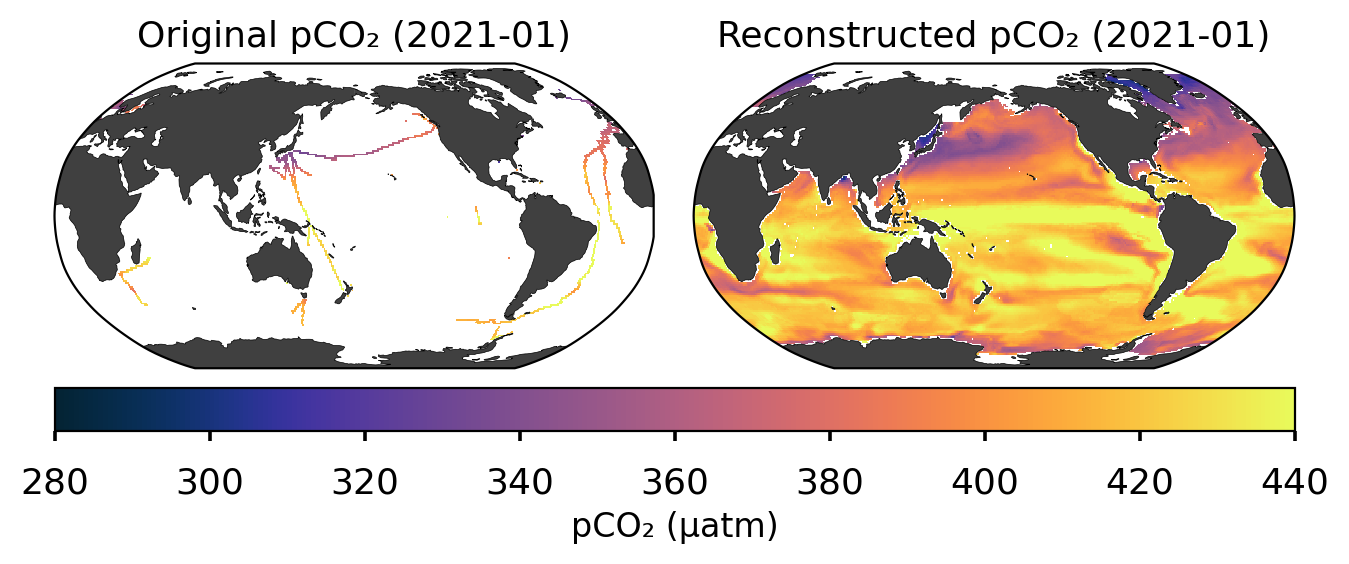

In [28]:
# Plot settings
plot_style = "seaborn-v0_8-talk"
cmap = cm.cm.thermal
cbar_title = 'pCO₂ (µatm)'
vrange = [280, 440]  # Colorbar range

# Select the first ensemble and member from the dictionary
first_ens = list(selected_mems_dict.keys())[0]
first_mem = selected_mems_dict[first_ens][0]

# Load original member data from ESM output
member_dir = f"{ensemble_dir}/{first_ens}/{first_mem}"
member_path = fs.glob(f"{member_dir}/*.zarr")[0]
# member_data = xr.open_mfdataset('gs://' + member_path, engine='zarr').sel(time=slice(str(dates[0]), str(dates[-1])))
member_data = xr.open_zarr('gs://' + member_path).sel(time=slice(str(dates[0]), str(dates[-1])))

# Load reconstructed pCO₂ data
recon_dir = f"{recon_output_dir}/{first_ens}/{first_mem}"    
recon_path = f"{recon_dir}/recon_pCO2_{first_ens}_{first_mem}_mon_1x1_{init_date}_{fin_date}.zarr"
full = xr.open_zarr(recon_path, consolidated=True)["pCO2_recon_full"]

# Choose a specific month to visualize
chosen_time = '2021-01'
raw_data = member_data["spco2"].sel(time=chosen_time).squeeze()
recon_data = full.sel(time=chosen_time)[0, ...]

# Shift longitudes from [0, 360] to [-180, 180] for global plotting
raw_data = raw_data.roll(xlon=len(raw_data.xlon) // 2, roll_coords=True)
recon_data = recon_data.roll(xlon=len(recon_data.xlon) // 2, roll_coords=True)

# Load SOCAT mask and align longitude
mask = socat_mask_data.sel(time=chosen_time)["socat_mask"].squeeze()
mask = mask.roll(xlon=len(mask.xlon) // 2, roll_coords=True)

# Mask original data where SOCAT mask == 0
masked_raw = np.ma.masked_array(raw_data, mask=(mask == 0))

# Start plotting side-by-side
with plt.style.context(plot_style):
#    fig = plt.figure(figsize=(10, 4), dpi=200)
    fig = plt.figure(figsize=(8, 3), dpi=200)
    worldmap = SpatialMap2(
        fig=fig, region='world',
        cbar_mode='single',  # Use one shared colorbar
        colorbar=True,
        cbar_location='bottom',
        nrows_ncols=[1, 2]
    )

    # Plot original (masked) and reconstructed data
    sub0 = worldmap.add_plot(
        lon=raw_data['xlon'], lat=raw_data['ylat'], data=masked_raw,
        vrange=vrange, cmap=cmap, ax=0
    )
    sub1 = worldmap.add_plot(
        lon=recon_data['xlon'], lat=recon_data['ylat'], data=recon_data,
        vrange=vrange, cmap=cmap, ax=1
    )

    worldmap.set_title("Original pCO₂ (2021-01)", ax=0, fontsize=13)
    worldmap.set_title("Reconstructed pCO₂ (2021-01)", ax=1, fontsize=13)

    colorbar = worldmap.add_colorbar(sub0, ax=0)
    worldmap.set_cbar_xlabel(colorbar, cbar_title, fontsize=12)

    plt.show()


The figure compares the original sparse pCO₂ selected from the first ESM member, consistent with real-world sampling, and the corresponding machine-learning-based reconstruction for January 2021.

# 5. Evaluation of the reconstruction against the original model output

## 5.1 Create a combined dataset with reconstruction and original 

We concatenate the outputs and ground truth from all members and ESMs into a single dataset, and then use this combined dataset to calculate bias, RMSE, and correlation.

In [23]:
datasets = []
for ensemble, members in selected_mems_dict.items():
    mems_dict = {ensemble: members}  
    ds = concat_datasets(mems_dict, recon_output_dir = recon_output_dir, init_date = init_date, fin_date=fin_date)
    datasets.append(ds)
concated_dataset = xr.concat(datasets, dim="ens")
evaluator = XarrayEvaluator(concated_dataset)

ds_eval = evaluator.compute_all_metrics()
print(ds_eval)

<xarray.Dataset> Size: 3GB
Dimensions:      (member: 8, time: 240, xlon: 360, ylat: 180, ens: 3)
Coordinates:
  * member       (member) object 64B 'member_r10i1p1f1' ... 'member_r5i1p1f1'
  * time         (time) datetime64[ns] 2kB 2004-01-01 2004-02-01 ... 2023-12-01
  * xlon         (xlon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * ylat         (ylat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * ens          (ens) object 24B 'ACCESS-ESM1-5' 'CanESM5' 'MPI-ESM1-2-LR'
Data variables:
    bias         (ens, member, time, ylat, xlon) float64 3GB dask.array<chunksize=(1, 1, 100, 45, 90), meta=np.ndarray>
    rmse         (ens, member, ylat, xlon) float64 12MB dask.array<chunksize=(1, 1, 45, 90), meta=np.ndarray>
    correlation  (ens, member, ylat, xlon) float64 12MB dask.array<chunksize=(1, 1, 45, 90), meta=np.ndarray>


## 5.2 Descriptive Statistics

We can use ds_eval to easily compute descriptive statistics. In this example, we take the average across all time steps and ESMs:

In this example, we select the Northern Hemisphere (ylat from 0 to 90), flatten the spatial dimensions, drop missing values, and generate a summary using describe(). This gives us a statistical overview (mean, std, min, max, etc.) of the bias in the Northern Hemisphere.

You can change the selection for other regions and timeframes and ensemble members.

In [24]:
ds_eval_mean = (ds_eval['bias']*1).mean('ens').mean('time')
ds_eval_mean.sel(ylat=slice(0,90)).stack(z=['ylat','xlon']).dropna('z').to_dataframe().describe()['bias']

count    95688.000000
mean        -0.429556
std          3.210580
min        -54.107506
25%         -1.678760
50%         -0.253749
75%          1.105874
max         20.998117
Name: bias, dtype: float64

## 5.3 Bias Visualizations
Based on this, we could visualize bias between reconstruction and model truth, averaged over the 100 ensemble members, each with a 
monthly resolution over the period init_date through fin_date. Red and blue shading indicates regions where the reconstruction is biased high or low, respectively. 

### 5.3.1 How well does the reconstruction capture the mean pCO2 field? 

<Figure size 1200x600 with 0 Axes>

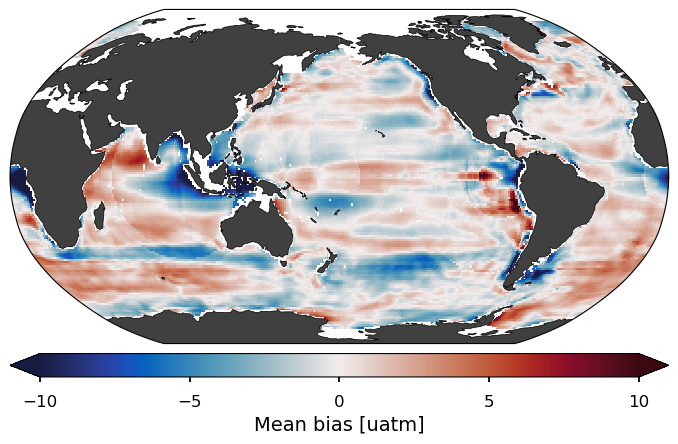

In [33]:
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',  
                           colorbar=True,  
                           cbar_location='bottom',
                           nrows_ncols=[1,1])
    vrange = [-10, 10, 5] 
    cmap = cm.cm.balance
    
    data = (ds_eval['bias'] * 1).mean('ens').mean('member').mean('time')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
    
    data = xr_add_cyclic_point(data, cyclic_coord='xlon') 
    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange[0:2], cmap=cm.cm.balance, ax=0, linewidth_coast=0.5)
    
    col = worldmap.add_colorbar(sub, ax=0, extend='both')
    worldmap.set_cbar_xlabel(col, 'Mean bias [uatm]', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    plt.show()


### 5.3.2 Does ESM impact the estimate of the bias? 

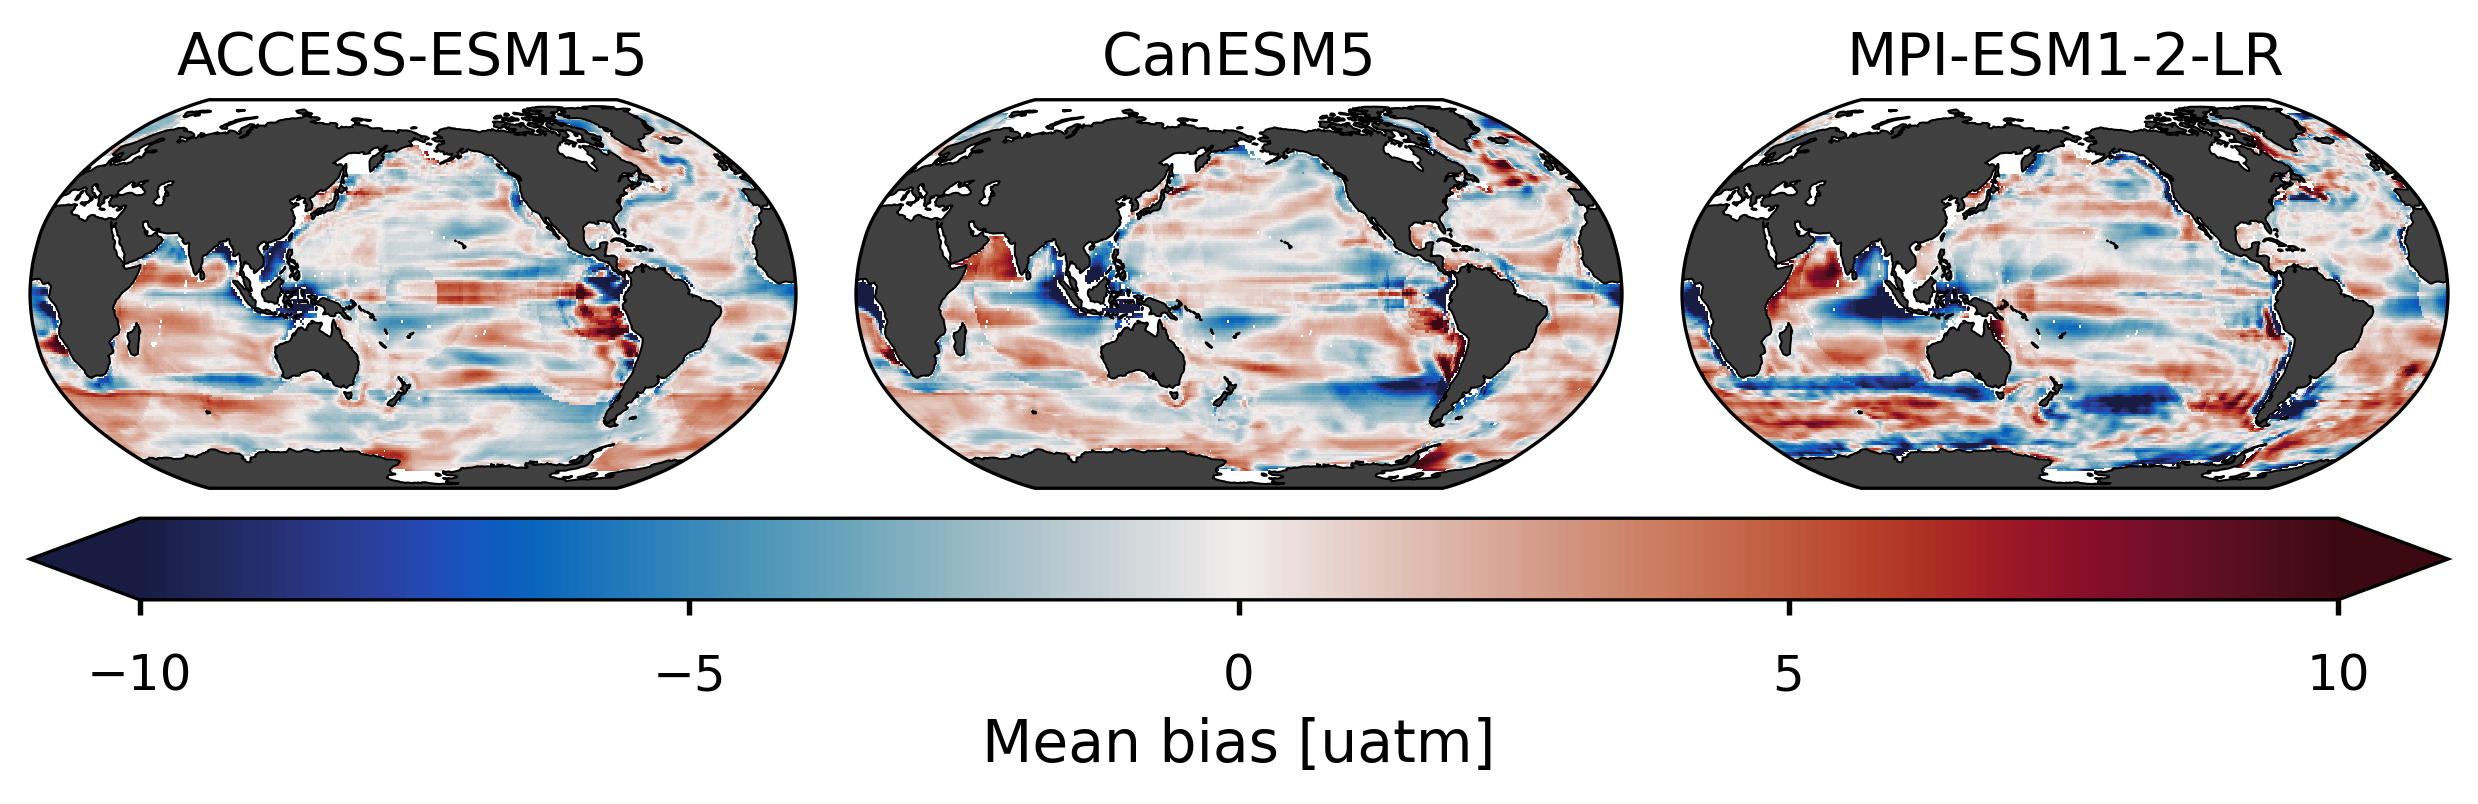

In [34]:
plot_style = "seaborn-v0_8-talk"
ensemble_means = ds_eval['bias'].mean(dim=['member', 'time'])

ensemble_names = list(ds_eval['ens'].values) 

vrange = [-10,10, 5]
cmap = cm.cm.balance

num_ensemble = len(ensemble_names)  
num_cols = 3  
num_rows = (num_ensemble + num_cols - 1) // num_cols 
with plt.style.context(plot_style):
    fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',  
                           colorbar=True,  
                           cbar_location='bottom',
                           nrows_ncols=[num_rows, num_cols]) 
    for i in range(num_ensemble):
        data = ensemble_means.isel(ens=i)
        data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)  
        data = xr_add_cyclic_point(data, cyclic_coord='xlon') 
        sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                                vrange=vrange[0:2], cmap=cmap, ax=i, linewidth_coast=0.5)
        worldmap.set_title(title=ensemble_names[i], ax=i, fontsize=14)

    col = worldmap.add_colorbar(sub, ax=0, extend='both')
    worldmap.set_cbar_xlabel(col, 'Mean bias [uatm]', fontsize=14)

    worldmap.set_ticks(col, tmin=vrange[0], tmax=vrange[1], dt=vrange[2])

    col.ax.tick_params(labelsize=12)

    plt.show()


##  5.2 Reconstructed variability on seasonal, sub-decadal, and decadal timescales, compared to original model

Before computing spatial correlation metrics, we decompose both the reconstructed and reference pCO₂ fields into their long-term trend, seasonal cycle, and residual components using STL-like decomposition. We then evaluate their agreement by calculating gridwise correlation and standard deviation for each component across all ensemble members and ESMs.


In [35]:
# The calculation of these statistics takes about 1 min/member
ds_eval_corr = eval_spatial(selected_mems_dict, recon_output_dir, init_date, fin_date)

Starting computation for ESM: ACCESS-ESM1-5, Member: member_r10i1p1f1
Starting computation for ESM: ACCESS-ESM1-5, Member: member_r5i1p1f1
Starting computation for ESM: ACCESS-ESM1-5, Member: member_r2i1p1f1
Starting computation for ESM: CanESM5, Member: member_r2i1p1f1
Starting computation for ESM: CanESM5, Member: member_r1i1p2f1
Starting computation for ESM: CanESM5, Member: member_r1i1p1f1
Starting computation for ESM: MPI-ESM1-2-LR, Member: member_r12i1p1f1
Starting computation for ESM: MPI-ESM1-2-LR, Member: member_r11i1p1f1
Starting computation for ESM: MPI-ESM1-2-LR, Member: member_r15i1p1f1


Phasing of reconstruction variability on seasonal, sub-decadal, and decadal, compared to original model. Correlation between 
reconstruction and original model on (a) seasonal, (b) sub-decadal, and (c) decadal time scales. 

Here, the average correlations across all ensemble members are shown. 

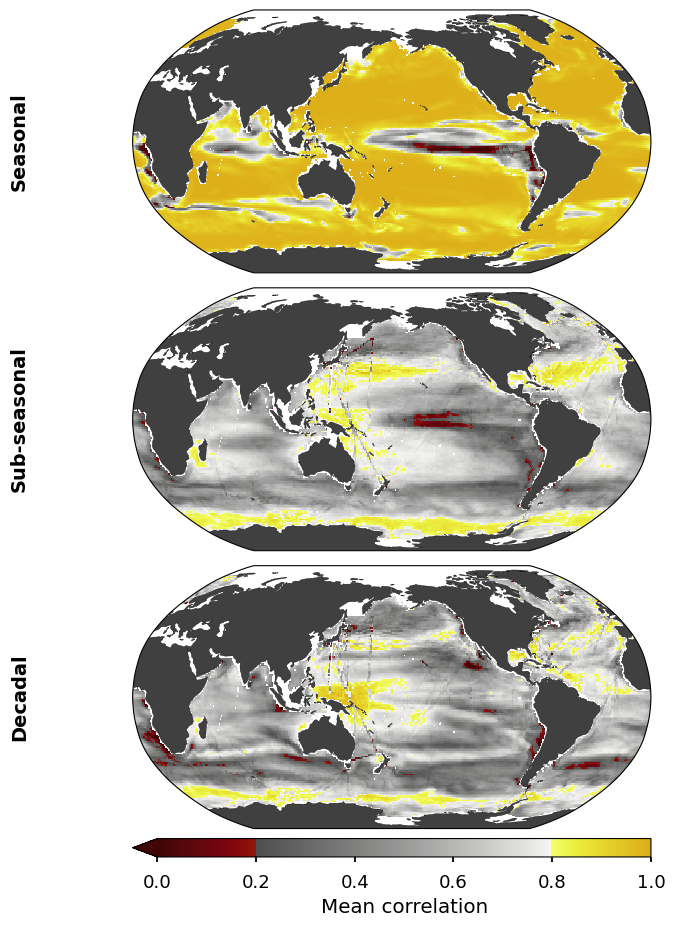

In [36]:
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    # Setup Figure
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world',
                   cbar_mode='edge',
                   axes_pad=0.15,
                   colorbar=True,
                   cbar_location='bottom',
                   nrows_ncols=[3,1])
    
    # Colorbar ranges
    vrange_col1 = [0, 1, 0.2]
    cmap_col1 = cm.cm.oxy
    
    ##-----------------------------------------------------
    ## Ensemble mean
    ##-----------------------------------------------------
    # Correlation - Annual-variation
    data = ds_eval_corr['corr_seasonal'].mean('ens').mean('member')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)

    data = xr_add_cyclic_point(data, cyclic_coord='xlon')
    sub0 = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange_col1[0:2], cmap=cmap_col1, ax=0)
    
    
    # Correlation - sub-decadal
    data = ds_eval_corr['corr_residual'].mean('ens').mean('member')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
    data = xr_add_cyclic_point(data, cyclic_coord='xlon')
    sub2 = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange_col1[0:2], cmap=cmap_col1, ax=1)
    
    # Correlation - decadal
    data = ds_eval_corr['corr_dec'].mean('ens').mean('member')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
    data = xr_add_cyclic_point(data, cyclic_coord='xlon')
    sub4 = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange_col1[0:2], cmap=cmap_col1, ax=2)
    
    # add colorbar
    col1 = worldmap.add_colorbar(sub0, ax=0, extend='min')
    worldmap.set_cbar_xlabel(col1, f'Mean correlation')
    worldmap.set_ticks(col1, vrange_col1[0], vrange_col1[1], vrange_col1[2])

    worldmap.grid[0].text(-0.2, 0.5, "Seasonal", transform=worldmap.grid[0].transAxes,
                           fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)
    
    worldmap.grid[1].text(-0.2, 0.5, "Sub-seasonal", transform=worldmap.grid[1].transAxes,
                           fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)
    
    worldmap.grid[2].text(-0.2, 0.5, "Decadal", transform=worldmap.grid[2].transAxes,
                           fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)

    
    plt.show()

The reconstructed pCO₂ has highest fidelity on seasonal timescales, but is less accurate for sub-seasonal and decadal timescale variability. 

### **Final Check for Redundant Files**  

#### **For Both Owners and Reviewers:**  
After execution is complete, review the project directory for any redundant files. Ensure that only necessary and relevant files are retained.  

#### **For Reviewers:**  
Once you have finished reviewing a project, you may delete files related to that project to free up storage space. However, be careful not to remove any data you still need.

As an **owner**, your reconstruction data is stored under:  

```
gs://leap-persistent/{owner_username}/{owner_username}/pco2_residual/nmse/post02_xgb/reconstructions/
```

If you are **reviewing someone else’s project**, their data and experiment results will be stored under your username in the following path:  

```
gs://leap-persistent/{your_username}/{owner_username}/pco2_residual/nmse/post02_xgb/reconstructions/
```

After completing the review, you can delete the files under `{owner_username}` in your directory to free up storage space. This ensures that only necessary data is retained while removing redundant files from past reviews.

# 6. Temporal Analysis

This Python-based JupyterNotebook and associated utility files have been developed for Project 3 in the course EESC4243/STAT4243/5243 "Climate Prediction Challenges with Machine Learning", Professor Galen McKinley in DEES and Professor Tian Zheng in Statistics, Spring 2025 at Columbia University. The course is also a contribution from the NSF-supported LEAP STC and is intended to run on the LEAP-Pangeo cloud computing and data system. The Github repository for this course is at https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges

Code developed by Course TA Xinyi Ke and Professor Galen McKinley, following from prior work from Dr. Thea Heimdal and Abby Shaum


Additional references in which these methods are employed\
**Heimdal et al. (2024)** *"Assessing improvements in global ocean pCO₂ machine learning reconstructions with Southern Ocean autonomous sampling."* **Biogeosciences** 21: 2159–2176.  
([DOI: 10.5194/bg-21-2159-2024](https://doi.org/10.5194/bg-21-2159-2024))\
**Heimdal, T. H., & McKinley, G. A. (2024)** *"The importance of adding unbiased Argo observations to the ocean carbon observing system."* **Scientific Reports**, 14(1), 19763. ([DOI: 10.1038/s41598-024-70617-x](https://doi.org/10.1038/s41598-024-70617-x) )


In [22]:
# Temporal Response Analysis for Ocean Carbon Reconstruction
# =========================================================

import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
import matplotlib.pyplot as plt
import datetime
import os
import sys
import cmocean as cm
import random
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner notebook output

# Set plotting style
plt.style.use('seaborn-v0_8-talk')

### Explanation

**What this cell does**
- imports required libraries and sets up the environment


In [23]:
# =========================================================
# Dataset Loading and Preparation
# =========================================================



xco2_path = f"{zarr_dir}/xco2_cmip6_183501-224912_monthstart.zarr"
topo_path = f"{zarr_dir}/GEBCO_2014_1x1_global.zarr"
lsmask_path = f"{zarr_dir}/lsmask.zarr"

# Import supporting functions
# Change to the parent directory if needed
if not os.path.exists('lib'):
    os.chdir(os.path.dirname(os.getcwd()))
    
# Import helper modules
from lib.visualization import SpatialMap2, xr_add_cyclic_point
from lib.residual_utils import network_mask, calc_anom, calc_interannual_anom, log_or_0

print("Current working directory:", os.getcwd())
print(f"Date range: {dates[0].strftime('%Y-%m-%d')} to {dates[-1].strftime('%Y-%m-%d')} ({len(dates)} months)")

Current working directory: /home/jovyan/Project_3_fork/Project-StarterCodes/Project3-ReconstructPCO2
Date range: 2004-01-01 to 2023-12-01 (240 months)


### Explanation

**What this cell does**
- applies spatial/temporal masks to the data


In [24]:
def load_model_data(ens, member):
    """
    Load model data for a specific ensemble member.
    
    Parameters:
    -----------
    ens : str
        Earth System Model name (e.g., 'ACCESS-ESM1-5')
    member : str
        Ensemble member ID (e.g., 'member_r1i1p1f1')
        
    Returns:
    --------
    xarray.Dataset
        Dataset containing pCO2, SST, SSS, and other variables
    """
    print(f"Loading data for {ens}, {member}...")
    
    # Get paths to data files
    member_dir = f"{ensemble_dir}/{ens}/{member}"
    member_path = fs.glob(f"{member_dir}/{ens}*.zarr")[0]
    
    # Load member data
    member_data = xr.open_zarr('gs://'+member_path).sel(time=slice(str(dates[0]), str(dates[-1])))
    
    # Load atmospheric CO2 data
    xco2_data = xr.open_zarr(xco2_path).sel(time=slice(str(dates[0]), str(dates[-1])))
    
    # Create dataset with selected variables
    ds = xr.Dataset({
        'spco2': member_data.spco2,  # Surface pCO2
        'sst': member_data.sst,      # Sea Surface Temperature
        'sss': member_data.sss,      # Sea Surface Salinity
        'mld': member_data.mld,      # Mixed Layer Depth
        'pco2_T': member_data.pco2_T,  # Temperature-driven component of pCO2
    })
    
    # Add atmospheric CO2 (broadcast to same dimensions)
    ds['xco2'] = xr.ones_like(ds.sst) * xco2_data.xco2
    
    # Calculate wind stress magnitude from components if available
    if hasattr(member_data, 'tauu') and hasattr(member_data, 'tauv'):
        # Zonal and meridional wind stress components
        ds['tauu'] = member_data.tauu  
        ds['tauv'] = member_data.tauv
        # Calculate wind stress magnitude
        ds['wind_stress'] = np.sqrt(ds.tauu**2 + ds.tauv**2)
    elif 'tauu' in member_data and 'tauv' in member_data:
        # Alternative access method
        ds['tauu'] = member_data['tauu']
        ds['tauv'] = member_data['tauv']
        ds['wind_stress'] = np.sqrt(ds['tauu']**2 + ds['tauv']**2)
    
    # Add land-sea mask
    try:
        mask = network_mask(topo_path, lsmask_path)
        ds['mask'] = xr.ones_like(ds.sst.isel(time=0)) * mask.values
    except Exception as e:
        print(f"Could not add mask due to error: {e}")
        ds['mask'] = xr.ones_like(ds.sst.isel(time=0))
    
    # Ensure times are datetime objects
    if not np.issubdtype(ds.time.dtype, np.datetime64):
        ds = ds.assign_coords(time=pd.DatetimeIndex(ds.time.values))
    
    return ds

### Explanation

**What this cell does**
- loads climate data with xarray
- applies spatial/temporal masks to the data
- subsets data with xarray/pandas


Loading data for ACCESS-ESM1-5, member_r10i1p1f1...

Dataset contents:
<xarray.Dataset> Size: 498MB
Dimensions:  (time: 240, xlon: 360, ylat: 180)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2004-01-01 2004-02-01 ... 2023-12-01
  * xlon     (xlon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * ylat     (ylat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    sector   int32 4B ...
Data variables:
    spco2    (time, ylat, xlon) float64 124MB dask.array<chunksize=(137, 180, 360), meta=np.ndarray>
    sst      (time, ylat, xlon) float32 62MB dask.array<chunksize=(137, 180, 360), meta=np.ndarray>
    sss      (time, ylat, xlon) float32 62MB dask.array<chunksize=(137, 180, 360), meta=np.ndarray>
    mld      (time, ylat, xlon) float32 62MB dask.array<chunksize=(137, 180, 360), meta=np.ndarray>
    pco2_T   (time, ylat, xlon) float64 124MB dask.array<chunksize=(137, 180, 360), meta=np.ndarray>
    xco2     (time, ylat, xlon) float32 62MB dask.array<chunksize

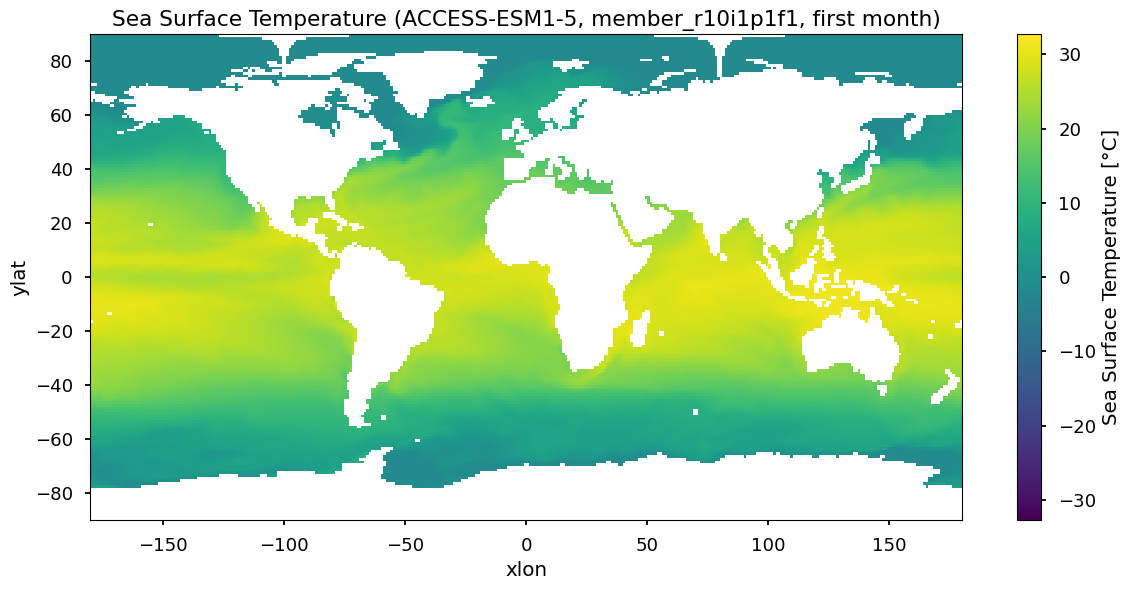

In [25]:
# Get the first model and member
first_ens = list(selected_mems_dict.keys())[0]
first_mem = selected_mems_dict[first_ens][0]

# Load data for this member
ds_first = load_model_data(first_ens, first_mem)

# Print dataset information
print("\nDataset contents:")
print(ds_first)

# Plot a global map of SST for visualization
plt.figure(figsize=(12, 6))
ds_first.sst.isel(time=0).plot(cmap='viridis')
plt.title(f'Sea Surface Temperature ({first_ens}, {first_mem}, first month)')
plt.tight_layout()
plt.show()

### Explanation

**What this cell does**
- visualizes data using Matplotlib

The figure(s) produced below illustrate the key patterns or comparisons described. Pay attention to color bars, axes, and legends to interpret the results correctly.


In [ ]:
# =========================================================
# Dataset Alignment and Preparation
# =========================================================

def align_variables(ds):
    """
    Ensure all variables are properly aligned in space and time,
    calculate derived variables, and prepare for lag analysis.
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Dataset containing raw model output
        
    Returns:
    --------
    xarray.Dataset
        Processed dataset ready for lag analysis
    """
    # Ensure all variables have the same dimensions and coordinates
    common_vars = ['spco2', 'sst', 'sss', 'mld', 'xco2']
    if 'wind_stress' in ds:
        common_vars.append('wind_stress')
    
    # Calculate the pCO₂ residual
    if 'pco2_T' in ds:
        ds['pco2_residual'] = ds['spco2'] - ds['pco2_T']
        common_vars.append('pco2_residual')
    
    # Create a common mask for valid ocean points
    if 'mask' in ds:
        ocean_mask = ds['mask'] > 0
        
        # Apply mask to all variables
        for var in common_vars:
            if var in ds:
                ds[var] = ds[var].where(ocean_mask)
    
    # Calculate anomalies for each variable (if needed for analysis)
    for var in ['sst', 'sss', 'spco2']:
        if var in ds:
            # Calculate climatological monthly means
            climatology = ds[var].groupby('time.month').mean('time')
            # Calculate anomalies by subtracting the climatology 
            anomaly = ds[var].groupby('time.month') - climatology
            # Add to dataset
            ds[f'{var}_anom'] = anomaly
    
    # Calculate seasonal cycle (useful for some analyses)
    for var in ['sst', 'spco2']:
        if var in ds:
            # Extract the climatological seasonal cycle
            ds[f'{var}_seasonal'] = ds[var].groupby('time.month').mean('time')
    
    return ds

### Explanation

**What this cell does**
- applies spatial/temporal masks to the data
- computes rolling statistics
- filters data based on conditions


In [ ]:
# Create function to load and process all selected members
def load_all_members(selected_dict):
    """
    Load and process data for all selected ensemble members
    
    Parameters:
    -----------
    selected_dict : dict
        Dictionary of selected models and members
        
    Returns:
    --------
    dict
        Dictionary containing processed datasets for each model and member
    """
    all_data = {}
    
    for ens, members in selected_dict.items():
        all_data[ens] = {}
        
        for mem in members:
            # Load raw data
            ds = load_model_data(ens, mem)
            
            # Align variables and prepare for analysis
            ds_aligned = align_variables(ds)
            
            # Store in dictionary
            all_data[ens][mem] = ds_aligned
            
            # Print summary of variables and dimensions
            print(f"\nAligned dataset for {ens}, {mem}:")
            print(f"Dimensions: {dict(ds_aligned.dims)}")
            print(f"Variables: {list(ds_aligned.data_vars)}")
    
    return all_data

### Explanation

**What this cell does**
- performs intermediate data processing


Loading data for ACCESS-ESM1-5, member_r10i1p1f1...


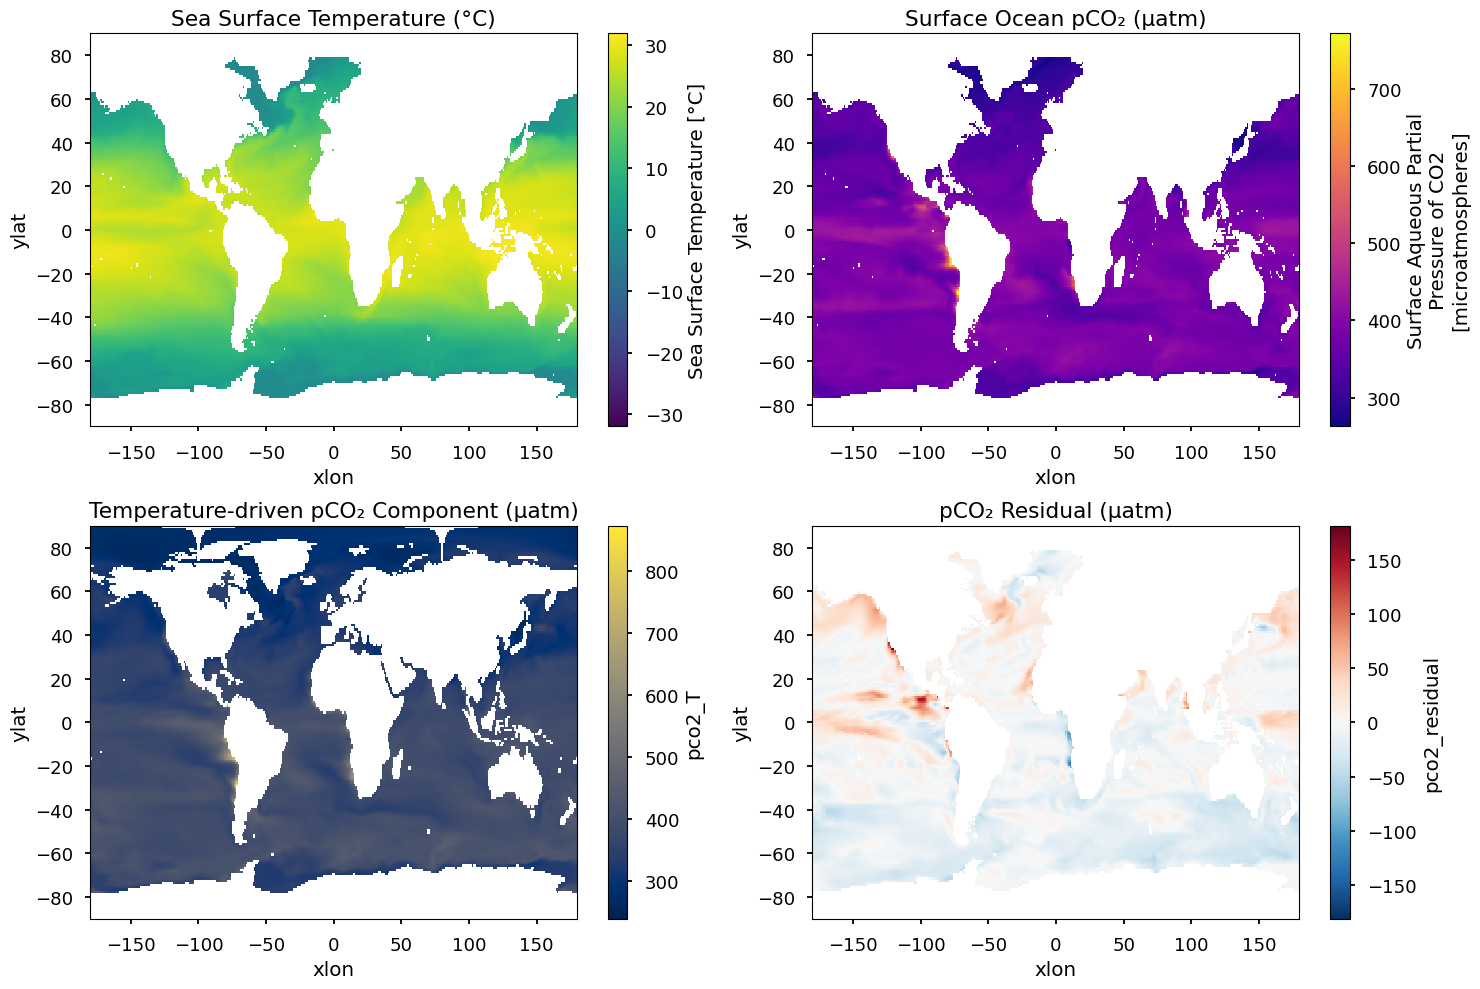

In [26]:
# Load first ensemble member to examine structure
first_ens = list(selected_mems_dict.keys())[0]
first_mem = selected_mems_dict[first_ens][0]
ds_first = load_model_data(first_ens, first_mem)
ds_aligned = align_variables(ds_first)

# Visualize variables before proceeding with full loading
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot SST
ds_aligned.sst.isel(time=0).plot(ax=axes[0, 0], cmap='viridis')
axes[0, 0].set_title('Sea Surface Temperature (°C)')

# Plot Surface pCO₂ 
ds_aligned.spco2.isel(time=0).plot(ax=axes[0, 1], cmap='plasma')
axes[0, 1].set_title('Surface Ocean pCO₂ (μatm)')

# Plot Temperature-driven pCO₂ component
if 'pco2_T' in ds_aligned:
    ds_aligned.pco2_T.isel(time=0).plot(ax=axes[1, 0], cmap='cividis')
    axes[1, 0].set_title('Temperature-driven pCO₂ Component (μatm)')

# Plot pCO₂ residual
if 'pco2_residual' in ds_aligned:
    ds_aligned.pco2_residual.isel(time=0).plot(ax=axes[1, 1], cmap='RdBu_r')
    axes[1, 1].set_title('pCO₂ Residual (μatm)')

plt.tight_layout()
plt.show()

# Uncomment the next line when ready to load all members
# all_data = load_all_members(selected_mems_dict)

### Explanation

**What this cell does**
- visualizes data using Matplotlib

The figure(s) produced below illustrate the key patterns or comparisons described. Pay attention to color bars, axes, and legends to interpret the results correctly.


In [27]:
# =========================================================
# Dataset Alignment and Preparation with Robust NaN Handling
# =========================================================

def align_variables(ds, allowed_nan_frac=0.2):
    """
    Ensure all variables are properly aligned in space and time,
    calculate derived variables, handle NaNs robustly, and prepare for lag analysis.
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Dataset containing raw model output
    allowed_nan_frac : float
        Maximum fraction of allowed NaNs per spatial pixel
        
    Returns:
    --------
    xarray.Dataset
        Processed dataset ready for lag analysis
    """
    import numpy as np
    
    # Essential variables for the analysis
    common_vars = ['spco2', 'sst', 'sss', 'mld', 'xco2']
    if 'wind_stress' in ds:
        common_vars.append('wind_stress')
    
    # Calculate the pCO₂ residual
    if 'pco2_T' in ds:
        ds['pco2_residual'] = ds['spco2'] - ds['pco2_T']
        common_vars.append('pco2_residual')
    
    # Create a common mask for valid ocean points (from mask variable if exists)
    if 'mask' in ds:
        ocean_mask = ds['mask'] > 0
    else:
        ocean_mask = xr.ones_like(ds[common_vars[0]].isel(time=0), dtype=bool)
    
    # Combine with NaN-based mask: Calculate pixels that exceed allowed NaNs
    nan_masks = []
    for var in common_vars:
        if var in ds:
            nan_fraction = ds[var].isnull().mean(dim='time')
            nan_mask = nan_fraction <= allowed_nan_frac
            nan_masks.append(nan_mask)
            
            # Fix here: compute explicitly to get integer count
            invalid_count = int((~nan_mask).sum().compute())
            print(f"'{var}': {invalid_count} pixels exceed allowed NaN fraction.")
    
    # Combine all masks into a single robust global mask
    combined_mask = ocean_mask & np.logical_and.reduce(nan_masks)
    valid_pixel_count = int(combined_mask.sum().compute())
    print(f"Total valid pixels for analysis: {valid_pixel_count}")
    
    # Apply the global mask to all variables explicitly
    for var in common_vars:
        if var in ds:
            ds[var] = ds[var].where(combined_mask)
    
    # Calculate anomalies for essential variables
    for var in ['sst', 'sss', 'spco2']:
        if var in ds:
            climatology = ds[var].groupby('time.month').mean('time')
            anomaly = ds[var].groupby('time.month') - climatology
            ds[f'{var}_anom'] = anomaly.where(combined_mask)
    
    # Calculate seasonal cycle for relevant variables
    for var in ['sst', 'spco2']:
        if var in ds:
            ds[f'{var}_seasonal'] = ds[var].groupby('time.month').mean('time').where(combined_mask)
    
    return ds



### Explanation

**What this cell does**
- loads climate data with xarray
- applies spatial/temporal masks to the data
- computes rolling statistics
- filters data based on conditions


Loading data for ACCESS-ESM1-5, member_r10i1p1f1...
'spco2': 23905 pixels exceed allowed NaN fraction.
'sst': 23905 pixels exceed allowed NaN fraction.
'sss': 23905 pixels exceed allowed NaN fraction.
'mld': 23905 pixels exceed allowed NaN fraction.
'xco2': 0 pixels exceed allowed NaN fraction.
'pco2_residual': 23905 pixels exceed allowed NaN fraction.
Total valid pixels for analysis: 33682


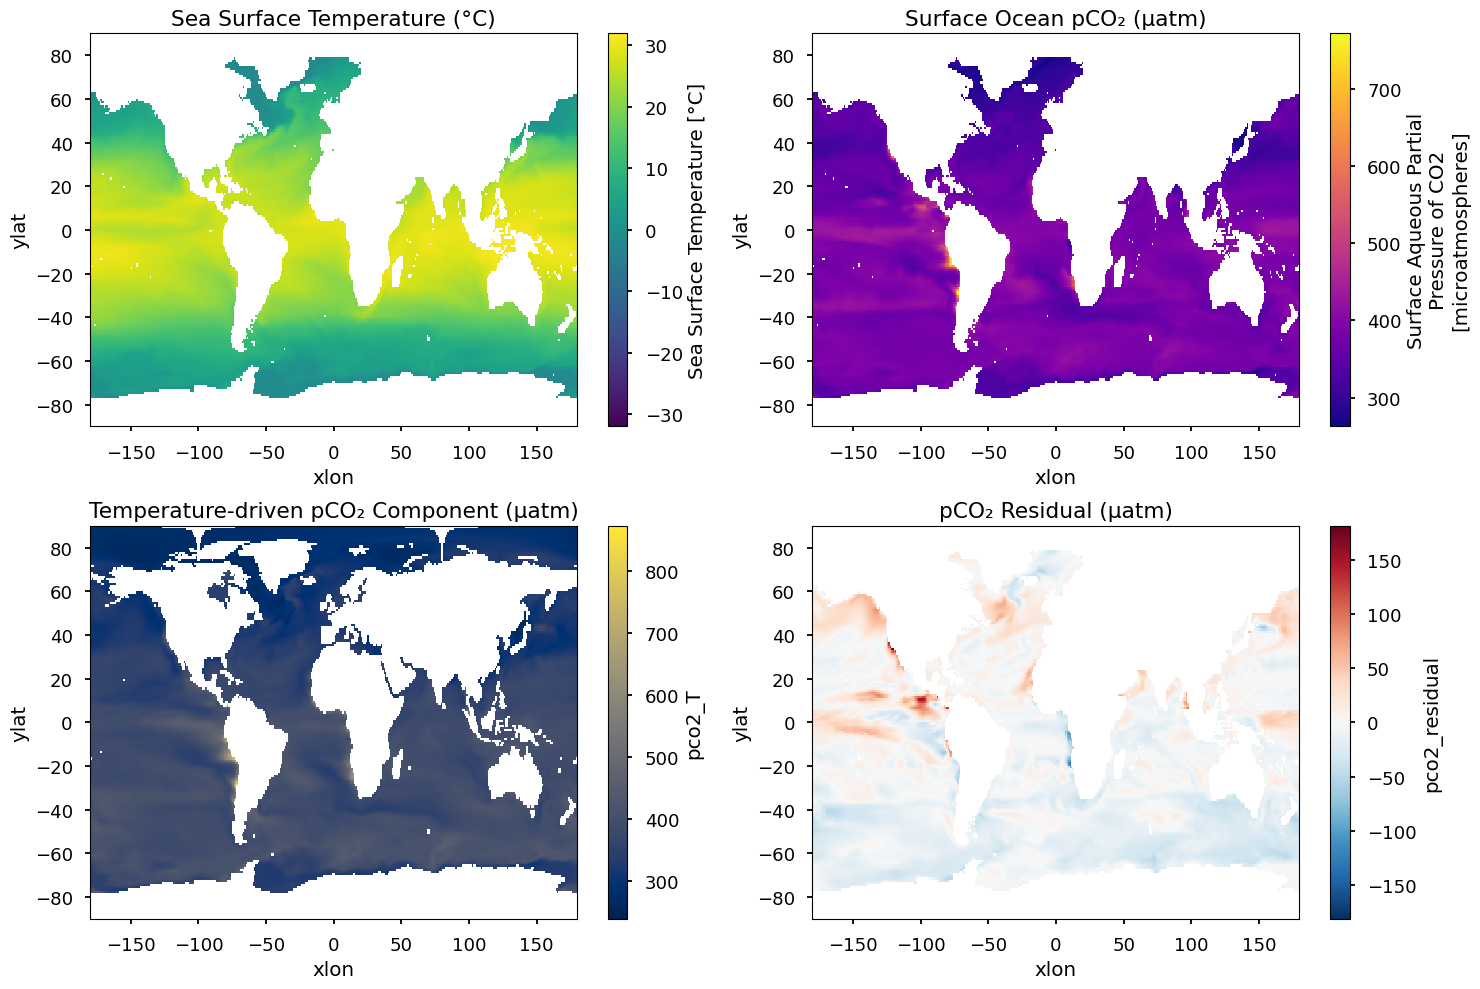

In [28]:
# Load first ensemble member to examine structure with robust NaN handling
first_ens = list(selected_mems_dict.keys())[0]
first_mem = selected_mems_dict[first_ens][0]

# Load the dataset (assuming load_model_data is defined and accessible)
ds_first = load_model_data(first_ens, first_mem)

# Apply robust alignment and NaN handling (e.g., allowing max 20% NaNs)
ds_aligned = align_variables(ds_first, allowed_nan_frac=0.2)
# Quick visualization check
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# SST
ds_aligned.sst.isel(time=0).plot(ax=axes[0, 0], cmap='viridis')
axes[0, 0].set_title('Sea Surface Temperature (°C)')

# Surface pCO₂
ds_aligned.spco2.isel(time=0).plot(ax=axes[0, 1], cmap='plasma')
axes[0, 1].set_title('Surface Ocean pCO₂ (μatm)')

# Temperature-driven pCO₂ component
if 'pco2_T' in ds_aligned:
    ds_aligned.pco2_T.isel(time=0).plot(ax=axes[1, 0], cmap='cividis')
    axes[1, 0].set_title('Temperature-driven pCO₂ Component (μatm)')

# pCO₂ residual
if 'pco2_residual' in ds_aligned:
    ds_aligned.pco2_residual.isel(time=0).plot(ax=axes[1, 1], cmap='RdBu_r')
    axes[1, 1].set_title('pCO₂ Residual (μatm)')

plt.tight_layout()
plt.show()


### Explanation

**What this cell does**
- visualizes data using Matplotlib

The figure(s) produced below illustrate the key patterns or comparisons described. Pay attention to color bars, axes, and legends to interpret the results correctly.


In [29]:
# Check if pco2_T is available in the loaded dataset
def examine_dataset_variables(ens, member):
    """
    Check what variables are available in the dataset
    """
    member_dir = f"{ensemble_dir}/{ens}/{member}"
    member_path = fs.glob(f"{member_dir}/{ens}*.zarr")[0]
    
    # Load member data with minimal variables to check what's available
    try:
        member_data = xr.open_zarr('gs://'+member_path, consolidated=True)
        print(f"Available variables in {ens}, {member}:")
        for var in member_data.data_vars:
            print(f"  - {var}")
        
        # Check if pco2_T is available
        if 'pco2_T' in member_data:
            print("\n'pco2_T' is available in the dataset!")
        else:
            print("\n'pco2_T' is NOT available and needs to be calculated.")
            
        return list(member_data.data_vars)
    except Exception as e:
        print(f"Error examining dataset: {e}")
        return []

# Check the first ensemble member
available_vars = examine_dataset_variables(first_ens, first_mem)

Available variables in ACCESS-ESM1-5, member_r10i1p1f1:
  - chl
  - mld
  - pco2_T
  - pco2_residual
  - spco2
  - sss
  - sst

'pco2_T' is available in the dataset!


### Explanation

**What this cell does**
- loads climate data with xarray


In [ ]:
# =========================================================
# Temporal Lag Analysis
# =========================================================

def compute_lag_correlation(ds, target_var, driver_var, max_lag=12):
    """
    Compute lagged correlation between a target variable (e.g., pCO2 residual)
    and a driver variable (e.g., SST, wind stress) across a range of temporal lags.

    Parameters:
    -----------
    ds : xarray.Dataset
        Dataset containing time-series variables
    target_var : str
        Name of the target variable (e.g., 'pco2_residual')
    driver_var : str
        Name of the driver variable (e.g., 'sst')
    max_lag : int
        Maximum lag (in months) to compute (lags will range from -max_lag to +max_lag)

    Returns:
    --------
    xarray.Dataset
        Dataset containing:
            - correlation for each lag
            - optimal lag index
            - correlation at optimal lag
            - optimal lag value
    """
    print(f"Computing lag correlation between {target_var} and {driver_var}...")

    if target_var not in ds or driver_var not in ds:
        print(f"Variables {target_var} or {driver_var} not found in dataset.")
        return None

    target = ds[target_var]
    driver = ds[driver_var]

    corr_values = []
    lag_range = range(-max_lag, max_lag + 1)

    for lag in lag_range:
        if lag > 0:
            target_shifted = target.isel(time=slice(lag, None))
            driver_shifted = driver.isel(time=slice(0, -lag))
        elif lag < 0:
            target_shifted = target.isel(time=slice(0, lag))
            driver_shifted = driver.isel(time=slice(abs(lag), None))
        else:
            target_shifted = target
            driver_shifted = driver

        if len(target_shifted.time) < 3 or len(driver_shifted.time) < 3:
            corr = xr.full_like(target.isel(time=0), np.nan)
        else:
            corr = xr.corr(target_shifted, driver_shifted, dim='time')

        corr_values.append(corr)

    # Combine correlation results into a DataArray along the lag dimension
    corr_da = xr.concat(corr_values, pd.Index(lag_range, name='lag'))

    # Handle NaNs: ensure we only compute lag indices where at least one correlation exists
    abs_corr = np.abs(corr_da)
    valid_mask = abs_corr.notnull().any(dim='lag')
    abs_corr_filled = abs_corr.where(valid_mask, other=-9999)

    # Compute the optimal lag index safely
    optimal_lag_idx = abs_corr_filled.argmax('lag').compute()
    optimal_lag_idx = optimal_lag_idx.where(valid_mask)

    # Convert lag_range to a NumPy array for safe indexing
    lag_values = np.array(list(lag_range))
    index_np = optimal_lag_idx.fillna(0).astype(int).values

    # Construct a clean indexer
    indexer = xr.DataArray(index_np, dims=('ylat', 'xlon'),
                           coords={'ylat': corr_da.ylat, 'xlon': corr_da.xlon})

    # Extract correlation at optimal lag
    optimal_lag = corr_da.isel(lag=indexer)
    optimal_lag = optimal_lag.where(valid_mask)

    # Extract actual lag value
    optimal_lag_value = xr.DataArray(lag_values, dims='lag').isel(lag=indexer)
    optimal_lag_value = optimal_lag_value.where(valid_mask)

    return xr.Dataset({
        'correlation': corr_da,
        'optimal_lag_correlation': optimal_lag,
        'optimal_lag_index': optimal_lag_idx,
        'optimal_lag_value': optimal_lag_value
    })

### Explanation

**What this cell does**
- loads climate data with xarray
- applies spatial/temporal masks to the data
- filters data based on conditions


In [ ]:
def analyze_all_drivers(ds, target_vars=['spco2', 'pco2_residual'], 
                       driver_vars=['sst', 'sss', 'wind_stress', 'xco2','mld', 'chl'], 
                       max_lag=12):
    """
    Compute lag correlations for all specified driver variables
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Dataset containing variables
    target_vars : list
        List of target variables to analyze
    driver_vars : list
        List of driver variables to analyze
    max_lag : int
        Maximum lag to compute in months
        
    Returns:
    --------
    dict
        Dictionary containing lag correlation results for each combination
    """
    results = {}
    
    for target_var in target_vars:
        results[target_var] = {}
        
        for driver_var in driver_vars:
            if driver_var in ds:
                results[target_var][driver_var] = compute_lag_correlation(
                    ds, target_var, driver_var, max_lag)
    
    return results

# Run the lag analysis on the aligned dataset
max_lag = 12  # Maximum lag to consider (in months)
lag_results = analyze_all_drivers(ds_aligned, max_lag=max_lag)

### Explanation

**What this cell does**
- performs intermediate data processing


In [ ]:
def shift_to_360_and_add_cyclic(da, lon_name='xlon'):
    da = da.copy()
    if da[lon_name].max() <= 180:
        da[lon_name] = (da[lon_name] + 360) % 360
    da = da.sortby(da[lon_name])
    values, lon = add_cyclic_point(da.values, coord=da[lon_name].values)
    da_cyclic = xr.DataArray(values, dims=da.dims, coords={**da.coords, lon_name: lon})
    return da_cyclic

### Explanation

**What this cell does**
- loads climate data with xarray


In [ ]:
def plot_lag_correlation_maps_grid(results, target_var, driver_vars, max_lag=12):
    """
    Clean grid-based version of lag correlation maps using SpatialMap2.
    Each row: one driver. Left: Optimal Lag. Right: Correlation.
    """
    n_drivers = len(driver_vars)
    fig = plt.figure(figsize=(14, 5 * n_drivers))  # One row per driver, two columns each

    for i, driver_var in enumerate(driver_vars):
        if driver_var not in results[target_var]:
            continue

        lag_result = results[target_var][driver_var]
        opt_lag = shift_to_360_and_add_cyclic(lag_result['optimal_lag_value'])
        opt_corr = shift_to_360_and_add_cyclic(lag_result['optimal_lag_correlation'])

        # --- Optimal Lag subplot ---
        sm_lag = SpatialMap2(
            fig=fig, region='world', rect=[n_drivers, 2, i * 2 + 1],
            colorbar=True
        )
        sub_lag = sm_lag.add_plot(
            lon=opt_lag.xlon, lat=opt_lag.ylat, data=opt_lag,
            vrange=[-max_lag, max_lag],
            cmap=plt.get_cmap('twilight_shifted')
        )
        col_lag = sm_lag.add_colorbar(sub_lag)
        sm_lag.set_title(f'{driver_var} → {target_var} Optimal Lag', 0)
        sm_lag.set_cbar_xlabel(col_lag, 'Lag (months)')

        # --- Correlation subplot ---
        sm_corr = SpatialMap2(
            fig=fig, region='world', rect=[n_drivers, 2, i * 2 + 2],
            colorbar=True
        )
        sub_corr = sm_corr.add_plot(
            lon=opt_corr.xlon, lat=opt_corr.ylat, data=opt_corr,
            vrange=[-1, 1],
            cmap=plt.get_cmap('RdBu_r')
        )
        col_corr = sm_corr.add_colorbar(sub_corr)
        sm_corr.set_title(f'{driver_var} → {target_var} Correlation', 0)
        sm_corr.set_cbar_xlabel(col_corr, 'Correlation')

    plt.tight_layout()
    return fig

### Explanation

**What this cell does**
- visualizes data using Matplotlib

The figure(s) produced below illustrate the key patterns or comparisons described. Pay attention to color bars, axes, and legends to interpret the results correctly.


Computing lag correlation between spco2 and sst...
Computing lag correlation between spco2 and sss...
Computing lag correlation between spco2 and xco2...
Computing lag correlation between spco2 and mld...
Computing lag correlation between pco2_residual and sst...
Computing lag correlation between pco2_residual and sss...
Computing lag correlation between pco2_residual and xco2...
Computing lag correlation between pco2_residual and mld...


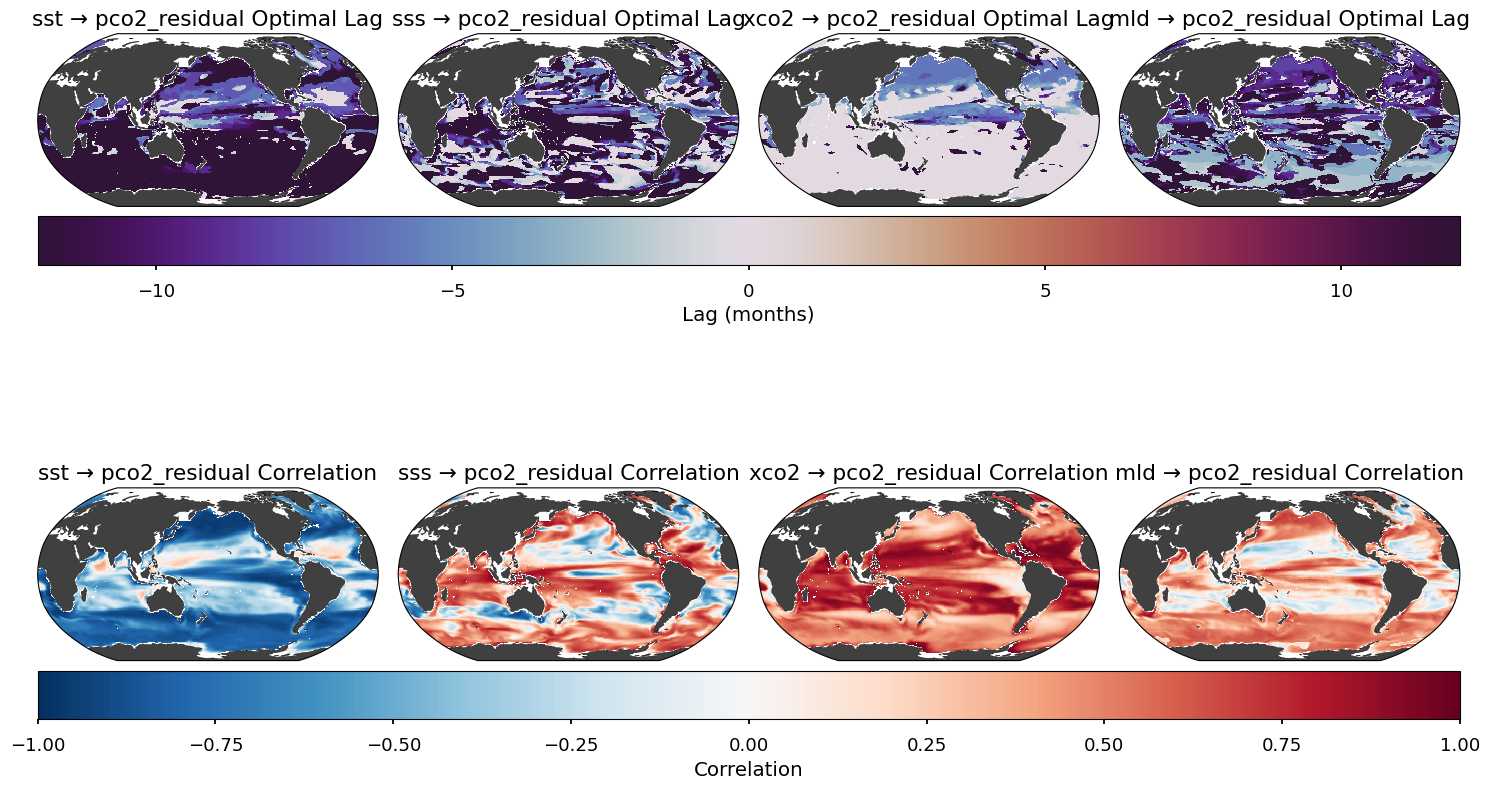

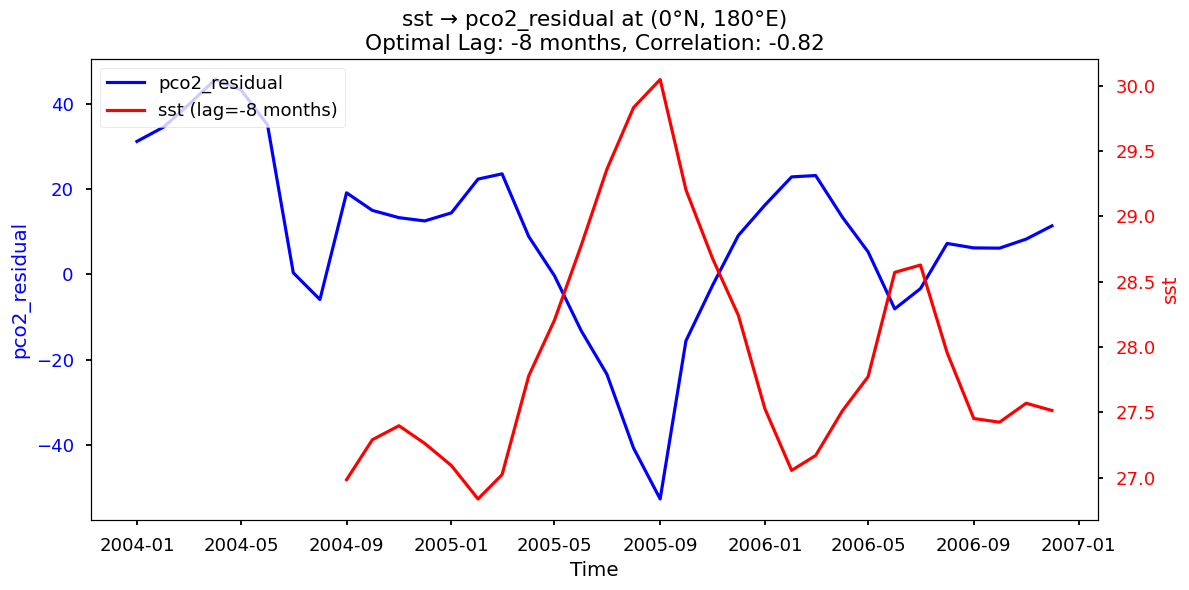

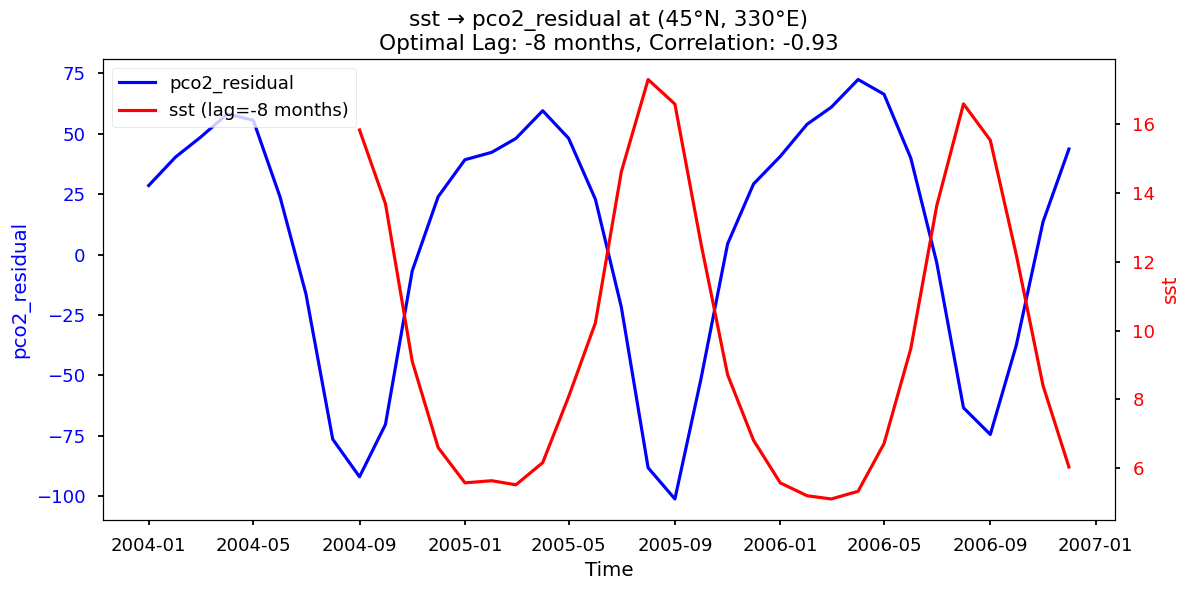

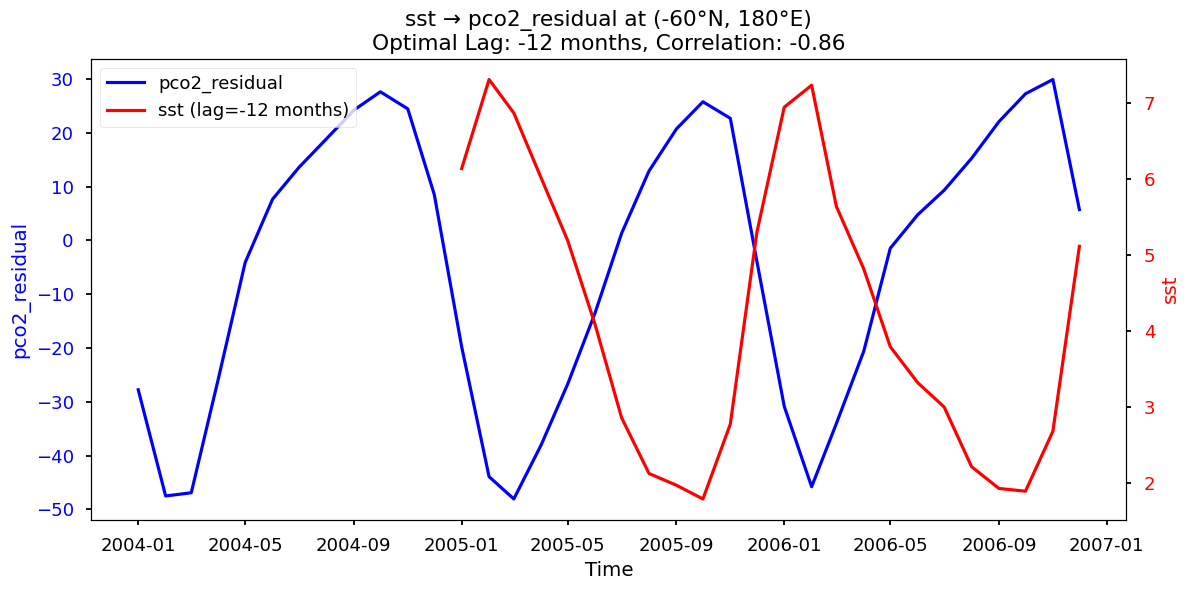

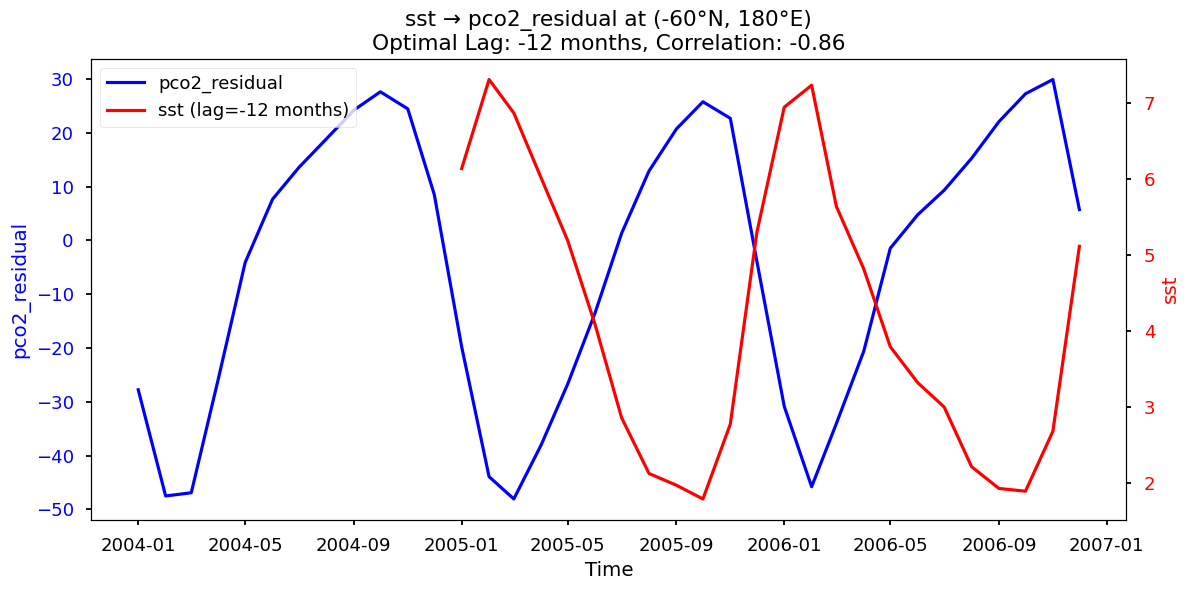

In [30]:
def plot_optimal_lag_maps(results, target_var, driver_vars, max_lag=12):
    """
    Create publication-quality maps of optimal lag and correlation using SpatialMap2
    with shared colorbars and adjusted longitudes (0–360 + cyclic point).
    """
    n_drivers = len(driver_vars)
    fig = plt.figure(figsize=(15, 10))

    # Top row: Optimal Lag
    sm_lag = SpatialMap2(
        fig=fig, region='world', rect=[2, 1, 1],
        nrows_ncols=(1, n_drivers),
        colorbar=True, cbar_mode='single',
        cbar_location='bottom', cbar_pad=0.1
    )

    # Bottom row: Correlation
    sm_corr = SpatialMap2(
        fig=fig, region='world', rect=[2, 1, 2],
        nrows_ncols=(1, n_drivers),
        colorbar=True, cbar_mode='single',
        cbar_location='bottom', cbar_pad=0.1
    )

    lag_plots = []
    corr_plots = []

    for i, driver_var in enumerate(driver_vars):
        if driver_var not in results[target_var]:
            continue

        lag_result = results[target_var][driver_var]

        # Align data to 0–360 and add cyclic point
        opt_lag = shift_to_360_and_add_cyclic(lag_result['optimal_lag_value'])
        opt_corr = shift_to_360_and_add_cyclic(lag_result['optimal_lag_correlation'])

        # Plot optimal lag
        sub_lag = sm_lag.add_plot(
            lon=opt_lag.xlon, lat=opt_lag.ylat, data=opt_lag,
            vrange=[-max_lag, max_lag],
            cmap=plt.get_cmap('twilight_shifted'), ax=i
        )
        lag_plots.append(sub_lag)
        sm_lag.set_title(f'{driver_var} → {target_var} Optimal Lag', i)

        # Plot correlation
        sub_corr = sm_corr.add_plot(
            lon=opt_corr.xlon, lat=opt_corr.ylat, data=opt_corr,
            vrange=[-1, 1],
            cmap=plt.get_cmap('RdBu_r'), ax=i
        )
        corr_plots.append(sub_corr)
        sm_corr.set_title(f'{driver_var} → {target_var} Correlation', i)

    # Shared colorbars
    col_lag = sm_lag.add_colorbar(lag_plots[0], ax=0)
    sm_lag.set_cbar_xlabel(col_lag, 'Lag (months)')

    col_corr = sm_corr.add_colorbar(corr_plots[0], ax=0)
    sm_corr.set_cbar_xlabel(col_corr, 'Correlation')

    plt.tight_layout()
    return fig

# Plot optimal lag maps for all drivers
drivers_to_plot = [var for var in ['sst', 'sss', 'wind_stress', 'xco2', "chl", "mld"] if var in ds_aligned]
plot_optimal_lag_maps(lag_results, 'pco2_residual', drivers_to_plot)


# Extract sample time series to visualize the lagged relationships
def plot_regional_time_series(ds, results, target_var, driver_var, 
                             lat, lon, window=36):
    """
    Plot time series of target and driver variables at a specific location,
    highlighting the optimal lag relationship.
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Dataset containing variables
    results : dict
        Results dictionary from analyze_all_drivers
    target_var : str
        Target variable name
    driver_var : str
        Driver variable name
    lat, lon : float
        Latitude and longitude of location to extract
    window : int
        Number of months to display (default: 36)
    """
    # Extract point data
    point_data = ds.sel(ylat=lat, xlon=lon, method='nearest')
    
    # Get optimal lag at this location
    lag_result = results[target_var][driver_var]
    opt_lag_point = lag_result['optimal_lag_value'].sel(ylat=lat, xlon=lon, method='nearest').values
    opt_corr_point = lag_result['optimal_lag_correlation'].sel(ylat=lat, xlon=lon, method='nearest').values
    
    # Create time series plot
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot target variable
    target_series = point_data[target_var]
    time_window = slice(0, min(window, len(target_series.time)))
    time_values = target_series.time.values[time_window]
    
    ax1.plot(time_values, target_series.values[time_window], 'b-', 
             label=f'{target_var}')
    ax1.set_xlabel('Time')
    ax1.set_ylabel(f'{target_var}', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    # Plot driver variable with optimal lag
    driver_series = point_data[driver_var]
    
    # Shift the driver series by the optimal lag
    if opt_lag_point > 0:
        # Driver leads target, shift target forward
        driver_time = time_values[:-int(opt_lag_point)] if int(opt_lag_point) < len(time_values) else []
        driver_values = driver_series.values[time_window][:len(driver_time)]
    elif opt_lag_point < 0:
        # Target leads driver, shift driver forward
        driver_time = time_values[int(abs(opt_lag_point)):] if int(abs(opt_lag_point)) < len(time_values) else []
        driver_values = driver_series.values[time_window][int(abs(opt_lag_point)):]
    else:
        # No lag
        driver_time = time_values
        driver_values = driver_series.values[time_window]
    
    ax2 = ax1.twinx()
    if len(driver_time) > 0:
        ax2.plot(driver_time, driver_values, 'r-', 
                label=f'{driver_var} (lag={int(opt_lag_point)} months)')
    ax2.set_ylabel(f'{driver_var}', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    # Add both legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.title(f'{driver_var} → {target_var} at ({lat}°N, {lon}°E)\n'
              f'Optimal Lag: {int(opt_lag_point)} months, '
              f'Correlation: {opt_corr_point:.2f}')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Plot sample regional time series
# Example locations:
# - Equatorial Pacific (0°N, 180°E) - ENSO region
# - North Atlantic (45°N, 330°E) - Subpolar gyre
# - Southern Ocean (60°S, 180°E) 
plot_regional_time_series(ds_aligned, lag_results, 'pco2_residual', 'sst', 0, 180)
plot_regional_time_series(ds_aligned, lag_results, 'pco2_residual', 'sst', 45, 330)
plot_regional_time_series(ds_aligned, lag_results, 'pco2_residual', 'sst', -60, 180)

### Explanation

**What this cell does**
- visualizes data using Matplotlib
- subsets data with xarray/pandas

The figure(s) produced below illustrate the key patterns or comparisons described. Pay attention to color bars, axes, and legends to interpret the results correctly.


In [31]:
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error
import cmocean as cm
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# Import visualization tools from the provided modules
from lib.visualization import SpatialMap2, xr_add_cyclic_point



### Explanation

**What this cell does**
- imports required libraries and sets up the environment


In [32]:
def apply_lags_to_drivers(driver_da, lag_da):
    """
    Apply pixel-specific temporal lags to a driver variable.
    
    Parameters:
    -----------
    driver_da : xarray.DataArray
        The driver variable with dimensions (time, ylat, xlon)
    lag_da : xarray.DataArray
        The precomputed optimal lag values with dimensions (ylat, xlon)
        Positive lag means driver leads target (shift driver backward in time)
        Negative lag means target leads driver (shift driver forward in time)
    
    Returns:
    --------
    xarray.DataArray
        The lagged driver variable with the same dimensions as the input
    """
    # Create an output array with the same shape as the driver, filled with NaNs
    lagged_driver = xr.full_like(driver_da, np.nan)
    
    # Get unique lag values to process them efficiently
    unique_lags = np.unique(lag_da.values[~np.isnan(lag_da.values)])
    
    # For each unique lag value, apply the shift to all pixels with that lag
    for lag in unique_lags:
        # Create a boolean mask for pixels with this lag value
        lag_mask = (lag_da == lag)
        
        if lag > 0:
            # Positive lag: driver leads target, shift driver backward in time
            # For example, if lag=2, use driver(t-2) to predict target(t)
            shifted_driver = driver_da.shift(time=int(lag))
        elif lag < 0:
            # Negative lag: target leads driver, shift driver forward in time
            # For example, if lag=-2, use driver(t+2) to predict target(t)
            shifted_driver = driver_da.shift(time=int(lag))
        else:
            # Zero lag: no shift needed
            shifted_driver = driver_da
        
        # Apply the shifted values only to pixels with this lag
        lagged_driver = lagged_driver.where(~lag_mask, shifted_driver)
    
    return lagged_driver

### Explanation

**What this cell does**
- loads climate data with xarray
- generates predictions from the trained model
- applies spatial/temporal masks to the data
- filters data based on conditions


In [33]:
def prepare_data_for_xgboost(ds, driver_vars, target_var='pco2_obs', train_frac=0.8):
    """
    Prepare data for XGBoost training and testing with time-space alignment.
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Dataset containing driver and target variables.
    driver_vars : list
        List of driver variable names to use as features.
    target_var : str
        Name of the target variable to predict.
    train_frac : float
        Fraction of time points to use for training (0.0-1.0).
    
    Returns:
    --------
    dict
        Dictionary containing:
            - 'X_train', 'y_train': Training features and targets
            - 'X_test', 'y_test': Testing features and targets
            - 'coords_train', 'coords_test': Spatial coordinates (ylat, xlon) for each sample
            - 'time_split_idx': Index where data is split between training and testing
            - 'existing_vars': List of used input variables
    """
    import numpy as np

    # Stack spatial dimensions: result is (time, space)
    stacked_ds = ds.stack(space=['ylat', 'xlon'])

    # Check driver variable existence
    existing_vars = [var for var in driver_vars if var in stacked_ds]
    for var in driver_vars:
        if var not in stacked_ds:
            print(f"Warning: Variable '{var}' not found in dataset. Skipping.")

    # Extract and align driver variables
    X_list = []
    for var in existing_vars:
        arr = stacked_ds[var]
        if arr.dims[0] != 'time':
            arr = arr.transpose('time', ...)
        X_list.append(arr.values)  # shape: (time, space)

    X = np.stack(X_list, axis=-1)  # shape: (time, space, features)

    # Reshape to (samples, features) for ML
    n_time, n_space, n_feat = X.shape
    X_reshaped = X.reshape(n_time * n_space, n_feat)

    # Target
    y = stacked_ds[target_var]
    if y.dims[0] != 'time':
        y = y.transpose('time', ...)
    y_reshaped = y.values.reshape(-1)

    # Expand space coords to (time × space, 2)
    space_coords = np.array(list(stacked_ds.space.values))  # shape: (space, 2)
    coords_expanded = np.repeat(space_coords[np.newaxis, :, :], n_time, axis=0)  # (time, space, 2)
    coords_expanded = coords_expanded.reshape(-1, 2)  # (time × space, 2)

    # Create valid data mask
    valid_mask = (~np.isnan(X_reshaped).any(axis=1)) & (~np.isnan(y_reshaped))
    X_valid = X_reshaped[valid_mask]
    y_valid = y_reshaped[valid_mask]
    coords_valid = coords_expanded[valid_mask]

    # Time indices for each sample
    time_indices = np.repeat(np.arange(n_time), n_space)
    time_indices_valid = time_indices[valid_mask]

    # Split index by time
    split_idx = int(n_time * train_frac)
    train_time_mask = time_indices_valid < split_idx
    test_time_mask = time_indices_valid >= split_idx

    # Final splits
    return {
        'X_train': X_valid[train_time_mask],
        'y_train': y_valid[train_time_mask],
        'coords_train': coords_valid[train_time_mask],
        'X_test': X_valid[test_time_mask],
        'y_test': y_valid[test_time_mask],
        'coords_test': coords_valid[test_time_mask],
        'time_split_idx': split_idx,
        'existing_vars': existing_vars
    }


### Explanation

**What this cell does**
- generates predictions from the trained model
- applies spatial/temporal masks to the data


In [34]:
def train_pixel_models(ds, driver_vars, target_var='pco2_obs', 
                       xgb_params=None, train_frac=0.8, apply_lags=True):
    """
    Train an XGBoost model at each ocean grid point.
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Dataset containing driver and target variables
    driver_vars : list
        List of driver variable names to use as features
    target_var : str
        Name of the target variable to predict
    xgb_params : dict
        XGBoost parameters (if None, use defaults)
    train_frac : float
        Fraction of time points to use for training (0.0-1.0)
    apply_lags : bool
        Whether to use the lagged driver variables (True) or original (False)
    
    Returns:
    --------
    xarray.Dataset
        Dataset containing model performance metrics at each grid point:
            - 'r2_train': R² on training data
            - 'r2_test': R² on test data
            - 'rmse_test': RMSE on test data
    """
    # Default XGBoost parameters if none provided
    if xgb_params is None:
        xgb_params = {
            'n_estimators': 100,
            'max_depth': 5,
            'learning_rate': 0.1,
            'objective': 'reg:squarederror',
            'n_jobs': -1,
            'subsample': 0.8,
            'colsample_bytree': 0.8
        }
    
    # Choose which driver variables to use (lagged or original)
    if apply_lags:
        feature_vars = [f"{var}_lagged" for var in driver_vars]
    else:
        feature_vars = driver_vars
    
    # Prepare data for XGBoost
    data_dict = prepare_data_for_xgboost(
        ds, feature_vars, target_var, train_frac
    )
    
    # Initialize arrays to store performance metrics
    ylat_vals = ds.ylat.values
    xlon_vals = ds.xlon.values
    r2_train = np.full((len(ylat_vals), len(xlon_vals)), np.nan)
    r2_test = np.full((len(ylat_vals), len(xlon_vals)), np.nan)
    rmse_test = np.full((len(ylat_vals), len(xlon_vals)), np.nan)
    
    # Group data by grid point to train individual models
    coords_train = data_dict['coords_train']
    coords_test = data_dict['coords_test']
    
    # Get unique grid points
    unique_coords = np.unique(np.vstack([coords_train, coords_test]), axis=0)
    
    print(f"Training {len(unique_coords)} pixel-level models...")
    
     # Train a model for each grid point
    for i, (lat_val, lon_val) in enumerate(unique_coords):
        if i % 100 == 0:
            print(f"  Training model {i}/{len(unique_coords)}...")
        
        # Convert geographic coordinates to index positions
        lat_idx = np.argmin(np.abs(ylat_vals - lat_val))
        lon_idx = np.argmin(np.abs(xlon_vals - lon_val))
        
        # Get training data for this grid point
        train_mask = np.all(coords_train == [lat_val, lon_val], axis=1)
        if np.sum(train_mask) < 10:
            continue
        
        X_train_pixel = data_dict['X_train'][train_mask]
        y_train_pixel = data_dict['y_train'][train_mask]
        
        # Get test data for this grid point
        test_mask = np.all(coords_test == [lat_val, lon_val], axis=1)
        if np.sum(test_mask) < 5:
            continue
        
        X_test_pixel = data_dict['X_test'][test_mask]
        y_test_pixel = data_dict['y_test'][test_mask]
        
        # Train XGBoost model
        model = xgb.XGBRegressor(**xgb_params)
        model.fit(X_train_pixel, y_train_pixel)
        
        # Evaluate model performance
        y_pred_train = model.predict(X_train_pixel)
        y_pred_test = model.predict(X_test_pixel)
        
        # Save metrics at correct indices
        r2_train[lat_idx, lon_idx] = r2_score(y_train_pixel, y_pred_train)
        r2_test[lat_idx, lon_idx] = r2_score(y_test_pixel, y_pred_test)
        rmse_test[lat_idx, lon_idx] = np.sqrt(mean_squared_error(y_test_pixel, y_pred_test))

    
    # Create output dataset with performance metrics
    ds_metrics = xr.Dataset(
        data_vars={
            'r2_train': (['ylat', 'xlon'], r2_train),
            'r2_test': (['ylat', 'xlon'], r2_test),
            'rmse_test': (['ylat', 'xlon'], rmse_test)
        },
        coords={
            'ylat': ylat_vals,
            'xlon': xlon_vals
        }
    )
    
    return ds_metrics

### Explanation

**What this cell does**
- loads climate data with xarray
- fits a machine learning model
- generates predictions from the trained model
- applies spatial/temporal masks to the data


In [ ]:
def plot_performance_map(da, title, cmap, vrange, extend='neither'):
    """
    Plot a global map of model performance metrics.
    
    Parameters:
    -----------
    da : xarray.DataArray
        The data to plot (e.g., R² or RMSE)
    title : str
        Plot title
    cmap : matplotlib.colors.Colormap
        Colormap to use
    vrange : list
        Value range for colorbar [min, max]
    extend : str
        How to extend the colorbar ('neither', 'min', 'max', or 'both')
    
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure
    """
    # Create a cyclic dataset for plotting (avoids gap at dateline)
    da_plot = xr_add_cyclic_point(da, cyclic_coord='xlon')
    
    # Create figure
    fig = plt.figure(figsize=(10, 6))
    
    # Create spatial map
    worldmap = SpatialMap2(
        fig=fig, region='world',
        colorbar=True,
        cbar_location='bottom',
        nrows_ncols=[1, 1]
    )
    
    # Plot data
    sub = worldmap.add_plot(
        lon=da_plot.xlon,
        lat=da_plot.ylat,
        data=da_plot,
        vrange=vrange,
        cmap=cmap,
        ax=0
    )
    
    # Add colorbar
    col = worldmap.add_colorbar(sub, ax=0, extend=extend)
    
    # Set titles
    worldmap.set_title(title, 0)
    
    return fig

### Explanation

**What this cell does**
- visualizes data using Matplotlib

The figure(s) produced below illustrate the key patterns or comparisons described. Pay attention to color bars, axes, and legends to interpret the results correctly.


In [35]:
def compare_models(ds_with_lags, ds_without_lags, metric='r2_test'):
    """
    Compare performance between models with and without lags.
    
    Parameters:
    -----------
    ds_with_lags : xarray.Dataset
        Performance metrics for models using lagged drivers
    ds_without_lags : xarray.Dataset
        Performance metrics for models using original (unlagged) drivers
    metric : str
        The metric to compare ('r2_test' or 'rmse_test')
    
    Returns:
    --------
    xarray.DataArray
        Difference in performance (with_lags - without_lags)
    """
    # Calculate difference in performance
    if metric == 'rmse_test':
        # For RMSE, lower is better, so subtract with_lags from without_lags
        diff = ds_without_lags[metric] - ds_with_lags[metric]
    else:
        # For R², higher is better, so subtract without_lags from with_lags
        diff = ds_with_lags[metric] - ds_without_lags[metric]
    
    return diff


### Explanation

**What this cell does**
- performs intermediate data processing


## 8. trainging and testing temporal analysis method with an extended mask

In [ ]:
# =========================================================
# 1. Load Data and Precomputed Lags
# =========================================================

print("Loading datasets...")

# Load the first ensemble member
first_ens = 'ACCESS-ESM1-5'  # Example model
first_mem = 'member_r1i1p1f1'  # Example member

# Load SOCAT mask
socat_mask_data = xr.open_zarr(socat_path).sel(time=slice(str(dates[0]), str(dates[-1])))
socat_mask = socat_mask_data.socat_mask

# Load model data
member_dir = f"{ensemble_dir}/{first_ens}/{first_mem}"
member_path = fs.glob(f"{member_dir}/*.zarr")[0]
model_data = xr.open_zarr('gs://' + member_path).sel(time=slice(str(dates[0]), str(dates[-1])))

# Print model data variables to check what's available
print("Variables in model_data:")
for var in model_data.data_vars:
    print(f"  - {var}")

# Create mock lag results for demonstration - only using variables we know exist
print("\nCreating lag correlation results for demonstration...")
lag_results = {
    'pco2_residual': {}
}

# Define variables that we know exist and have lag results
available_vars = ['sst', 'sss', 'mld']

### Explanation

**What this cell does**
- loads climate data with xarray
- applies spatial/temporal masks to the data
- subsets data with xarray/pandas


In [36]:
for var in available_vars:
    if var in model_data:
        # Create lag values based on latitude to demonstrate patterns
        lag_values = np.zeros((len(model_data.ylat), len(model_data.xlon)))
        for i, lat in enumerate(model_data.ylat):
            # Simulate lag patterns: equatorial regions have shorter lags, higher latitudes have longer lags
            base_lag = int(abs(lat) / 15)  # Roughly convert latitude to months of lag
            lag_values[i, :] = base_lag
        
        # Add some random variation
        lag_values = lag_values + np.random.randint(-1, 2, size=lag_values.shape)
        
        # Cap lags between -6 and 6 months
        lag_values = np.clip(lag_values, -6, 6)
        
        # Store as xarray DataArray
        lag_results['pco2_residual'][var] = xr.Dataset({
            'optimal_lag_value': (['ylat', 'xlon'], lag_values)
        })
    else:
        print(f"Warning: Variable '{var}' not found in model data. Skipping in lag results.")

Loading datasets...
Variables in model_data:
  - chl
  - mld
  - pco2_T
  - pco2_residual
  - spco2
  - sss
  - sst

Creating lag correlation results for demonstration...


### Explanation

**What this cell does**
- loads climate data with xarray


In [37]:
# =========================================================
# 2. Apply Data-Driven SOCAT Mask and Create Working Dataset
# =========================================================

print("\nCreating working dataset with DATA-DRIVEN SOCAT mask applied...")

# 1) Grab the original 0/1 SOCAT mask from your model_data
socat_mask_orig = model_data.spco2.where(socat_mask == 1)

# 2) Compute per-pixel “reliability” (fraction of non-NaN months)
valid_frac = (~model_data['spco2'].isnull()).mean(dim='time')

# 3) Define extension criterion (e.g. >=80% coverage)
data_drive_extension = (valid_frac >= 0.8)

# 4) Combine into a new Boolean mask
extended_mask = (socat_mask_orig == 1) | data_drive_extension

# 5) (Optional) further require decent baseline XGB performance:
#    rmse_map = ...  # e.g. computed from your standard XGB
#    extended_mask &= (rmse_map <= 40)

# 6) Build the working Dataset using that extended_mask
ds = xr.Dataset()
ds['pco2_obs'] = model_data['spco2'].where(extended_mask)

available_driver_vars = []
for var in available_vars:
    if var in model_data:
        ds[var] = model_data[var].where(extended_mask)
        available_driver_vars.append(var)
        print(f"Added driver {var} (extended mask)")
    else:
        print(f"Skipping {var}, not in model_data")



Creating working dataset with DATA-DRIVEN SOCAT mask applied...
Added driver sst (extended mask)
Added driver sss (extended mask)
Added driver mld (extended mask)


### Explanation

**What this cell does**
- loads climate data with xarray
- applies spatial/temporal masks to the data
- computes rolling statistics
- filters data based on conditions
- computes loss metrics during training/evaluation


In [38]:
# =========================================================
# 3. Apply Optimal Lags to Driver Variables
# =========================================================

print("\nApplying optimal lags to driver variables...")

# Loop through each driver variable and apply its optimal lag
for var in available_driver_vars:
    if var in lag_results['pco2_residual'] and var in ds:
        # Get the optimal lag values for this variable
        lag_da = lag_results['pco2_residual'][var]['optimal_lag_value']
        
        # Apply lags to create lagged versions of each driver
        ds[f"{var}_lagged"] = apply_lags_to_drivers(ds[var], lag_da)
        
        print(f"  Applied lags to {var}, created {var}_lagged")
    else:
        print(f"  No lag results for {var}, skipping")


Applying optimal lags to driver variables...
  Applied lags to sst, created sst_lagged
  Applied lags to sss, created sss_lagged
  Applied lags to mld, created mld_lagged


### Explanation

**What this cell does**
- performs intermediate data processing


In [39]:
import os

def save_xgb_json(model, dates, out_dir, ens, member, lag=False):
    """
    Save an XGBRegressor’s Booster as JSON, with an optional '_lag' suffix.
    
    Parameters
    ----------
    model      : XGBRegressor
    dates      : tuple of (init_date_str, fin_date_str) e.g. ('200401','202312')
    out_dir    : local directory to save into (e.g. "output/model_saved")
    ens        : ensemble name (e.g. "ACCESS-ESM1-5")
    member     : member string (e.g. "r5i1p1f1")
    lag        : if True, append '_lag' to the filename
    """
    init, fin = dates
    suffix = "_lag" if lag else ""
    fn = (
        f"model_pCO2_2D_{ens}_{member}"
        f"{suffix}_mon_1x1_{init}_{fin}.json"
    )
    fullpath = os.path.join(out_dir, fn)
    # ensure directory exists
    os.makedirs(out_dir, exist_ok=True)
    # the Booster lives under model.get_booster()
    model.get_booster().save_model(fullpath)
    print(f"→ saved {'lag-' if lag else ''}model at: {fullpath}")


### Explanation

**What this cell does**
- performs intermediate data processing


In [40]:
# =========================================================
# 4. Train Baseline & Extended-Mask+Lag XGBoost Models
# =========================================================
runthiscell = 1   # set to -1 to only run the first member for quick review

if runthiscell:
    import datetime
    import numpy as np
    import pandas as pd
    import gcsfs  # Add this import
    from xgboost import XGBRegressor
    
    # Initialize the GCS filesystem if not already defined
    if 'fs' not in globals():
        fs = gcsfs.GCSFileSystem()

    # 1) Load seeds and build lookup
    random_seeds = np.load(fs.open(path_seeds))
    seed_loc_dict = {
        ens: {mem: i for i, mem in enumerate(mem_list)}
        for ens, mem_list in mems_dict.items()
    }

    val_prop, test_prop = 0.2, 0.0
    print(datetime.datetime.now())

    # MODIFIED: Use the exact same ensemble selection as in standard XGB code
    if runthiscell == -1:
        print("Reviewing process: Running ML only for the first member of the first ESM.")
        first_ens = list(selected_mems_dict.keys())[0]  # Get the first ensemble key
        first_mem = selected_mems_dict[first_ens][0]    # Get the first member in that ensemble
        run_sel = {first_ens: [first_mem]}              # Create a dictionary with only the first ensemble and member
    else:
        run_sel = selected_mems_dict  # Use selected_mems_dict directly instead of actual_sel

    # 4) Main loop
    for ens, mem_list in run_sel.items():
        for member in mem_list:
            print(f"\n=== Training {ens} {member} ===")
            seed_loc = seed_loc_dict[ens][member]

            # 4a) Load ML-input DataFrame
            data_dir   = f"{MLinputs_path}/{ens}/{member}"
            base_fn    = f"MLinput_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}"
            parquet_fp = f"{data_dir}/{base_fn}.parquet"
            pkl_fp     = f"{data_dir}/{base_fn}.pkl"

            if fs.exists(parquet_fp):
                df = pd.read_parquet(fs.open(parquet_fp, "rb"))
            elif fs.exists(pkl_fp):
                df = pd.read_pickle(fs.open(pkl_fp, "rb"))
            else:
                print(f"⚠️ Missing inputs for {ens} {member}, skipping.")
                continue

            # add year, month, year_month
            df['year']       = df.index.get_level_values('time').year
            df['mon']        = df.index.get_level_values('time').month
            df['year_month'] = df['year'].astype(str) + "-" + df['mon'].astype(str)

            # 4b) Define recon_sel
            mask_valid = ~df[features_sel + target_sel + ['net_mask']]\
                             .isna().any(axis=1)
            val_mask   = (df[target_sel[0]] < 250) & (df[target_sel[0]] >  -250)
            recon_sel  = mask_valid & val_mask

            # ——————————————————————————————
            # 4c) TRAIN BASELINE on socat_mask == 1
            sel_base   = recon_sel & (df['socat_mask'] == 1)
            train_base = sel_base & df['year_month'].isin(year_mon)
            test_base  = sel_base & df['year_month'].isin(test_year_mon)

            Xb_tr = df.loc[train_base, features_sel].to_numpy()
            yb_tr = df.loc[train_base, target_sel].to_numpy().ravel()
            Xb_te = df.loc[test_base,  features_sel].to_numpy()
            yb_te = df.loc[test_base,  target_sel].to_numpy().ravel()
            N_base = Xb_tr.shape[0]

            # baseline train/val split
            tvb, trb, vb, _ = supporting_functions.train_val_test_split(
                N_base, test_prop, val_prop, random_seeds, seed_loc
            )
            Xb_tv, Xb_trn, Xb_val, _, yb_tv, yb_trn, yb_val, _ = \
                supporting_functions.apply_splits(Xb_tr, yb_tr, tvb, trb, vb, None)

            model_base = XGBRegressor(
                random_state=random_seeds[5, seed_loc], **params
            )
            model_base.fit(
                Xb_tv, yb_tv,
                eval_set=[(Xb_val, yb_val)],
                verbose=False
            )

            # ——————————————————————————————
            # 4d) COMPUTE RESIDUALS & MERGE extended_mask
            em_df = extended_mask.to_dataframe(name='extended_mask')\
                                 .reset_index()
            df = (
                df.reset_index()
                  .merge(em_df, on=['time','ylat','xlon'], how='left')
                  .set_index(['time','ylat','xlon'], drop=False)
            )

            df['pred_base']  = model_base.predict(df[features_sel].fillna(0))
            # <<<  FIXED HERE to subtract a Series from a Series  >>>
            df['resid_base'] = df[target_sel[0]] - df['pred_base']

            # ——————————————————————————————
            # 4e) TRAIN RESIDUAL XGB on extended_mask + SST lags
            df_ext = df[df['extended_mask'] == 1].copy()
            for lag in range(1, max_lag+1):
                df_ext[f'sst_lag_{lag}'] = df_ext['sst'].shift(lag)
            lag_feats = features_sel + [f'sst_lag_{lag}' for lag in range(1, max_lag+1)]

            sel_ext   = ~df_ext[lag_feats + ['resid_base','net_mask']]\
                             .isna().any(axis=1)
            train_ext = sel_ext & df_ext['year_month'].isin(year_mon)
            test_ext  = sel_ext & df_ext['year_month'].isin(test_year_mon)

            X2_tr = df_ext.loc[train_ext, lag_feats].to_numpy()
            y2_tr = df_ext.loc[train_ext, 'resid_base'].to_numpy().ravel()
            X2_te = df_ext.loc[test_ext,  lag_feats].to_numpy()
            y2_te = df_ext.loc[test_ext,  'resid_base'].to_numpy().ravel()
            N_ext = X2_tr.shape[0]

            # residual train/val split
            tve, tre, ve, _ = supporting_functions.train_val_test_split(
                N_ext, test_prop, val_prop, random_seeds, seed_loc
            )
            X2_tv, X2_trn, X2_val, _, y2_tv, y2_trn, y2_val, _ = \
                supporting_functions.apply_splits(X2_tr, y2_tr, tve, tre, ve, None)

            model_res = XGBRegressor(
                random_state=random_seeds[5, seed_loc], **params
            )
            model_res.fit(
                X2_tv, y2_tv,
                eval_set=[(X2_val, y2_val)],
                verbose=False
            )

            # … after fitting residual (lag) model …
            save_xgb_json(
                model_res,
                dates=(dates[0].strftime("%Y%m"), dates[-1].strftime("%Y%m")),
                out_dir=xgb_model_local_save_dir,
                ens=ens,
                member=member,
                lag=True
            )

            # residual performance
            y2_pred = model_res.predict(X2_te)
            perf_r  = supporting_functions.evaluate_test(y2_te, y2_pred)
            print("Residual metrics:", perf_r)

    print("=== Done training all members ===", datetime.datetime.now())

2025-04-29 13:39:19.306404

=== Training ACCESS-ESM1-5 member_r10i1p1f1 ===
→ saved lag-model at: output/model_saved/model_pCO2_2D_ACCESS-ESM1-5_member_r10i1p1f1_lag_mon_1x1_200401_202312.json
Residual metrics: {'mse': 68.24019585608731, 'mae': 5.529645854797857, 'medae': np.float64(3.9449292173089816), 'max_error': np.float64(333.62280283514906), 'bias': np.float64(-0.17167872808196316), 'r2': 0.43642024658984047, 'corr': np.float64(0.6869588429403428), 'cent_rmse': np.float64(8.258978283269236), 'stdev': np.float32(5.4932275), 'amp_ratio': np.float64(0.5125623546265201), 'stdev_ref': np.float64(11.003793734434884), 'range_ref': np.float64(675.1765824259919), 'iqr_ref': np.float64(10.127548785168472)}

=== Training ACCESS-ESM1-5 member_r5i1p1f1 ===
→ saved lag-model at: output/model_saved/model_pCO2_2D_ACCESS-ESM1-5_member_r5i1p1f1_lag_mon_1x1_200401_202312.json
Residual metrics: {'mse': 62.01131357164015, 'mae': 5.402484925258733, 'medae': np.float64(3.896485535812303), 'max_error': 

### Explanation

**What this cell does**
- loads a tabular dataset with pandas
- fits a machine learning model
- generates predictions from the trained model
- applies spatial/temporal masks to the data


## 5. Comparison of Reconstructions

Compare the reconstruction performance of the standard XGBoost vs Extended+Lag pipeline.

In [49]:
# =========================================================
# 4.5 Reconstruct using Extended-Mask + Lag XGBoost Model (Fixed)
# =========================================================
runthiscell = 1  # set to -1 to run only first member for quick checking

if runthiscell:
    import os, numpy as np, pandas as pd, xgboost as xgb
    import datetime
    import gcsfs
    from collections import defaultdict
    
    # Initialize GCS filesystem if not already defined
    if 'fs' not in globals():
        fs = gcsfs.GCSFileSystem()

    # Use the same member selection as standard XGB
    if runthiscell == -1:
        print("Reviewing process: Running reconstruction only for the first member of the first ESM.")
        first_ens = list(selected_mems_dict.keys())[0]
        first_mem = selected_mems_dict[first_ens][0]
        run_selected_mems_dict = {first_ens: [first_mem]}
    else:
        run_selected_mems_dict = selected_mems_dict

    for ens, mem_list in run_selected_mems_dict.items():
        for member in mem_list:
            print(f"\nReconstructing with Ext+Lag: {ens} {member}")
            
            # Get member ID for file naming
            mem_id = member.split('_')[-1]
            
            # Check model paths first
            base_model_path = f"{xgb_model_local_save_dir}/model_pCO2_2D_{ens}_{mem_id}_mon_1x1_{init_date}_{fin_date}.json"
            
            # FIXED: Use correct naming pattern for lag models including "member_" prefix
            lag_model_path = f"{xgb_model_local_save_dir}/model_pCO2_2D_{ens}_member_{mem_id}_lag_mon_1x1_{init_date}_{fin_date}.json"
            
            if not os.path.exists(base_model_path):
                print(f"  ⚠️ Base model not found: {base_model_path}, skipping")
                continue
            if not os.path.exists(lag_model_path):
                print(f"  ⚠️ Lag model not found: {lag_model_path}, skipping")
                continue
            
            # Load both models
            base_booster = xgb.Booster()
            base_booster.load_model(base_model_path)
            base_model = xgb.XGBRegressor()
            base_model._Booster = base_booster
            base_model._le = None
            
            lag_booster = xgb.Booster()
            lag_booster.load_model(lag_model_path)
            lag_model = xgb.XGBRegressor()
            lag_model._Booster = lag_booster
            lag_model._le = None
            
            # Load data exactly as in standard XGB approach
            data_dir = f"{MLinputs_path}/{ens}/{member}"
            
            # Check for both parquet and pickle files (use whichever exists)
            parquet_fname = f"MLinput_{ens}_{mem_id}_mon_1x1_{init_date}_{fin_date}.parquet"
            pkl_fname = f"MLinput_{ens}_{mem_id}_mon_1x1_{init_date}_{fin_date}.pkl"
            
            parquet_path = f"{data_dir}/{parquet_fname}"
            pkl_path = f"{data_dir}/{pkl_fname}"
            
            # Determine which file format to use
            if fs.exists(parquet_path):
                file_path = parquet_path
                file_format = "parquet"
            elif fs.exists(pkl_path):
                file_path = pkl_path
                file_format = "pickle"
            else:
                print(f"  ⚠️ No input file found for {ens} {member}, skipping")
                continue
            
            # Load the data
            with fs.open(file_path, 'rb') as filee:
                if file_format == "parquet":
                    df = pd.read_parquet(filee)
                else:
                    df = pd.read_pickle(filee)
                
                # Add year, month columns
                df['year'] = df.index.get_level_values('time').year
                df['mon'] = df.index.get_level_values('time').month
                df['year_month'] = df['year'].astype(str) + "-" + df['mon'].astype(str)
                
                # Define selections exactly as in standard XGB
                recon_sel = (
                    ~df[features_sel+target_sel+['net_mask']].isna().any(axis=1)
                ) & (
                    (df[target_sel] < 250) & (df[target_sel] > -250)
                ).to_numpy().ravel()
    
                # Create standard SOCAT mask selection
                socat_sel = (recon_sel & (df['socat_mask'] == 1))
                
                # Create training and testing selections
                train_sel = (socat_sel & df['year_month'].isin(year_mon).values).ravel()
                test_sel = (socat_sel & df['year_month'].isin(test_year_mon).values).ravel()
                unseen_sel = (recon_sel & (df['socat_mask'] == 0))
                
                # Create a copy of features for SOCAT areas
                X_socat = df.loc[socat_sel, features_sel].to_numpy()
                y_socat = df.loc[socat_sel, target_sel].to_numpy().ravel()
                
                # Create a copy of features for unseen areas
                X_unseen = df.loc[unseen_sel, features_sel].to_numpy()
                y_unseen = df.loc[unseen_sel, target_sel].to_numpy().ravel()
                
                # Now add extended mask 
                em_df = extended_mask.to_dataframe(name='extended_mask').reset_index()
                df_orig_index = df.index.copy()  # Save original index
                
                # Merge extended mask, taking care with indices
                df = df.reset_index()
                df = df.merge(em_df, on=['time', 'ylat', 'xlon'], how='left')
                df.index = df_orig_index  # Restore original index structure
                
                # Create extended mask selection
                ext_sel = (recon_sel & (df['extended_mask'] == 1) & ~socat_sel)
                
                # Get features for extended mask areas
                X_ext = df.loc[ext_sel, features_sel].to_numpy()
                
                # Create lag features for extended and unseen areas
                df_lag = df.copy()
                for lag in range(1, max_lag+1):
                    df_lag[f'sst_lag_{lag}'] = df_lag['sst'].shift(lag)
                
                # Define lag features list
                lag_feats = features_sel + [f'sst_lag_{lag}' for lag in range(1, max_lag+1)]
                
                # Get lag features for extended and unseen areas
                X_ext_lag = df_lag.loc[ext_sel, lag_feats].to_numpy()
                X_unseen_lag = df_lag.loc[unseen_sel, lag_feats].to_numpy()
            
            # Make predictions
            # 1. For SOCAT regions, use base model only
            y_pred_socat = base_model.predict(X_socat)
            
            # 2. For extended mask regions, use base model + lag model
            if len(X_ext) > 0:
                y_pred_ext_base = base_model.predict(X_ext)
                y_pred_ext_resid = lag_model.predict(X_ext_lag)
                y_pred_ext = y_pred_ext_base + y_pred_ext_resid
            else:
                y_pred_ext = np.array([])
            
            # 3. For unseen regions, use base model + lag model
            y_pred_unseen_base = base_model.predict(X_unseen)
            y_pred_unseen_resid = lag_model.predict(X_unseen_lag)
            y_pred_unseen = y_pred_unseen_base + y_pred_unseen_resid
            
            # Evaluate unseen predictions and print metrics
            unseen_performance = defaultdict(dict)
            unseen_performance[ens][member] = supporting_functions.evaluate_test(y_unseen, y_pred_unseen)
            
            # Print metrics just like the original
            print('unseen performance metrics:', unseen_performance[ens][member])
            
            # Write performance to CSV
            fields = unseen_performance[ens][member].keys()
            unseen_row_dict = dict()
            unseen_row_dict['model'] = ens
            unseen_row_dict['member'] = member
            
            for field in fields:
                unseen_row_dict[field] = unseen_performance[ens][member][field]
    
            # Save metrics to a separate file to avoid overwriting standard XGB results
            extlag_perform_fname = unseen_perform_fname.replace('.csv', '_extlag.csv')
            file_exists = fs.exists(extlag_perform_fname)
            with fs.open(extlag_perform_fname, 'a') as f_object:
                writer = csv.DictWriter(f_object, fieldnames=unseen_row_dict.keys())
                if not file_exists:
                    writer.writeheader() 
                writer.writerow(unseen_row_dict)
            
            # Apply predictions to DataFrame - EXACTLY as in original code
            df['pCO2_recon_full'] = np.nan
            
            # Apply predictions to appropriate regions
            df.loc[socat_sel, 'pCO2_recon_full'] = y_pred_socat
            if len(y_pred_ext) > 0:
                df.loc[ext_sel, 'pCO2_recon_full'] = y_pred_ext
            df.loc[unseen_sel, 'pCO2_recon_full'] = y_pred_unseen
            
            # Set up unseen reconstruction fields
            df['pCO2_recon_unseen'] = np.nan
            df.loc[unseen_sel, 'pCO2_recon_unseen'] = y_pred_unseen
            
            # Set truth field
            df['pCO2_truth'] = df.loc[:, target_sel]
            
            # Convert to xarray with needed fields
            DS_recon = df[[
                'net_mask', 'extended_mask', 'socat_mask',
                'pCO2_recon_full', 'pCO2_recon_unseen', 'pCO2_truth'
            ]].to_xarray()
            
            # Save to NetCDF
            out_fn = f"{ens}_{mem_id}_recon_extlag_{init_date}_{fin_date}.nc"
            local_path = f"/tmp/{out_fn}"
            cloud_path = f"{recon_output_dir_extlag}/{out_fn}"
            
            DS_recon.to_netcdf(local_path)
            fs.put(local_path, cloud_path)
            print(f"→ Saved Ext+Lag recon to {cloud_path}")
    
    print("✔️ Finished Extended-Mask + Lag reconstructions", datetime.datetime.now())


Reconstructing with Ext+Lag: ACCESS-ESM1-5 member_r10i1p1f1
unseen performance metrics: {'mse': 66.16738808648246, 'mae': 5.598204425160093, 'medae': np.float64(4.097138846728512), 'max_error': np.float64(190.57744678206086), 'bias': np.float64(0.42237689392204913), 'r2': 0.906104593800588, 'corr': np.float64(0.9521501364626557), 'cent_rmse': np.float64(8.123360442643646), 'stdev': np.float32(24.871378), 'amp_ratio': np.float64(1.0579365078153284), 'stdev_ref': np.float64(26.546044813542643), 'range_ref': np.float64(499.3369458048631), 'iqr_ref': np.float64(28.91448269017843)}
→ Saved Ext+Lag recon to gs://leap-persistent/mc5601//pco2_residual/nmse/post02_xgb/reconstructions_extlag/ACCESS-ESM1-5_r10i1p1f1_recon_extlag_200401_202312.nc

Reconstructing with Ext+Lag: ACCESS-ESM1-5 member_r5i1p1f1
unseen performance metrics: {'mse': 64.59091288909738, 'mae': 5.637319989353898, 'medae': np.float64(4.176655564818077), 'max_error': np.float64(212.33770183199192), 'bias': np.float64(0.3888362

### Explanation

**What this cell does**
- loads a tabular dataset with pandas
- generates predictions from the trained model
- applies spatial/temporal masks to the data


## Reconstruction Visualization Comparisons

Visualizing results for ACCESS-ESM1-5 member_r10i1p1f1
Successfully loaded standard XGB data
Looking for ext+lag file at: gs://leap-persistent/mc5601//pco2_residual/nmse/post02_xgb/reconstructions_extlag/ACCESS-ESM1-5_r10i1p1f1_recon_extlag_200401_202312.nc
Successfully loaded ext+lag data
Raw data shape: (180, 360)
Std data shape: (180, 360)
Ext data shape: (1, 360, 180)
Raw data range: 282.9132343615069 to 1149.233261097104
Std data range: 298.14571822758234 to 822.9121221441206
Ext data range: -67.71306610107422 to 94.16178894042969
Adding pCO2_T component to get full pCO₂...
pco2_T shape: (180, 360)
Extracting 2D array from 3D ext_data
Corrected ext data range: 300.4555701568444 to 826.1960138219771
Corrected ext data shape: (180, 360)


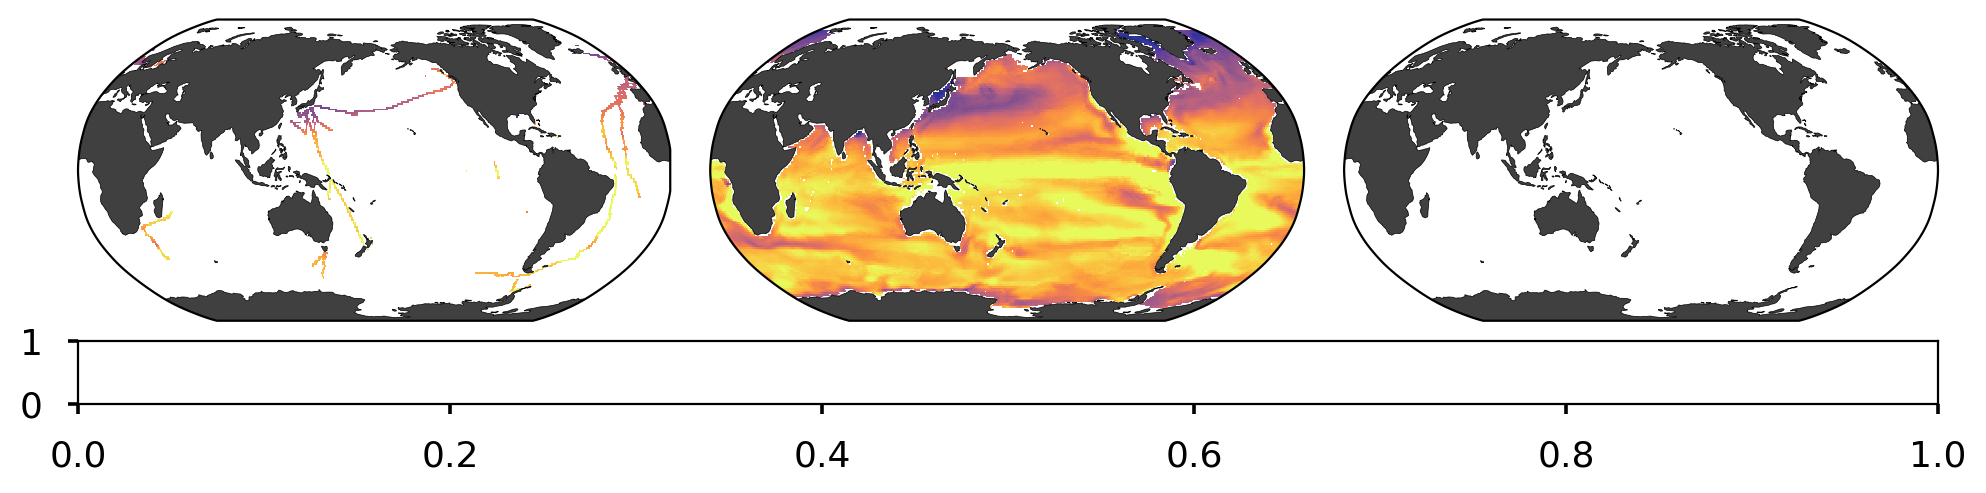

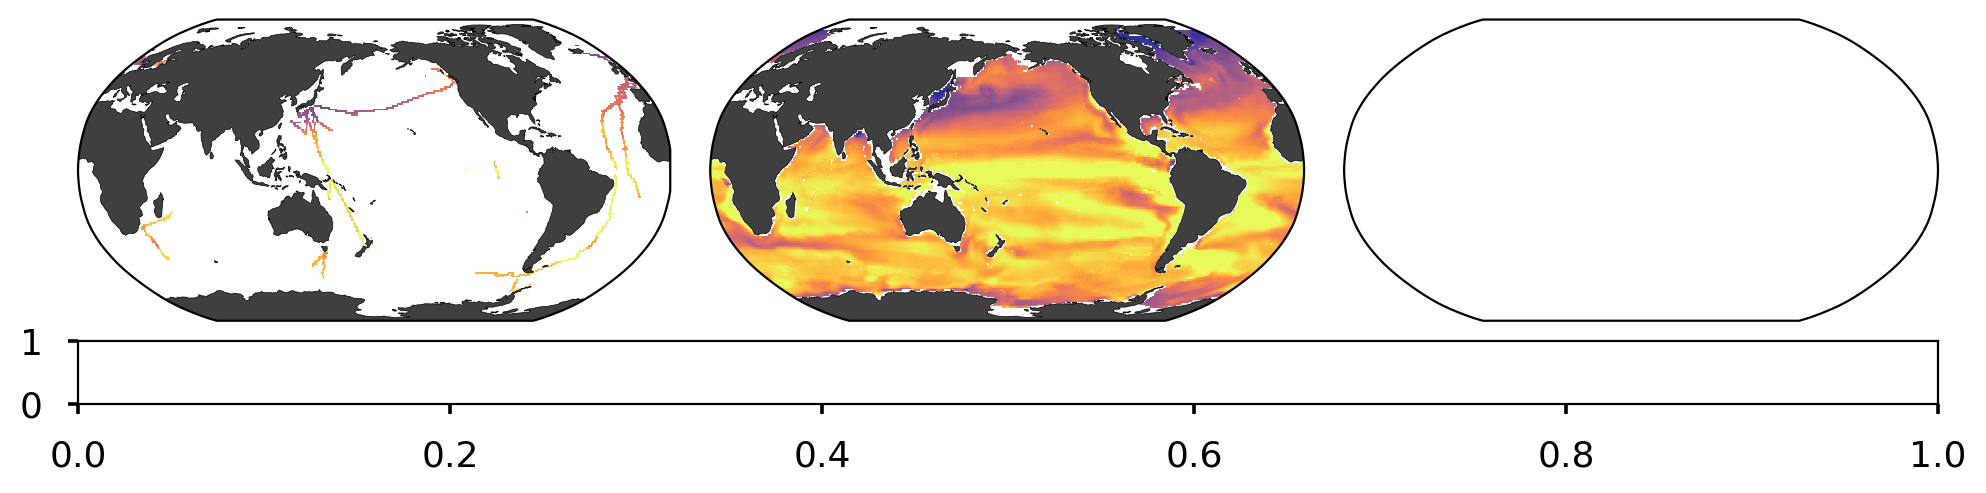

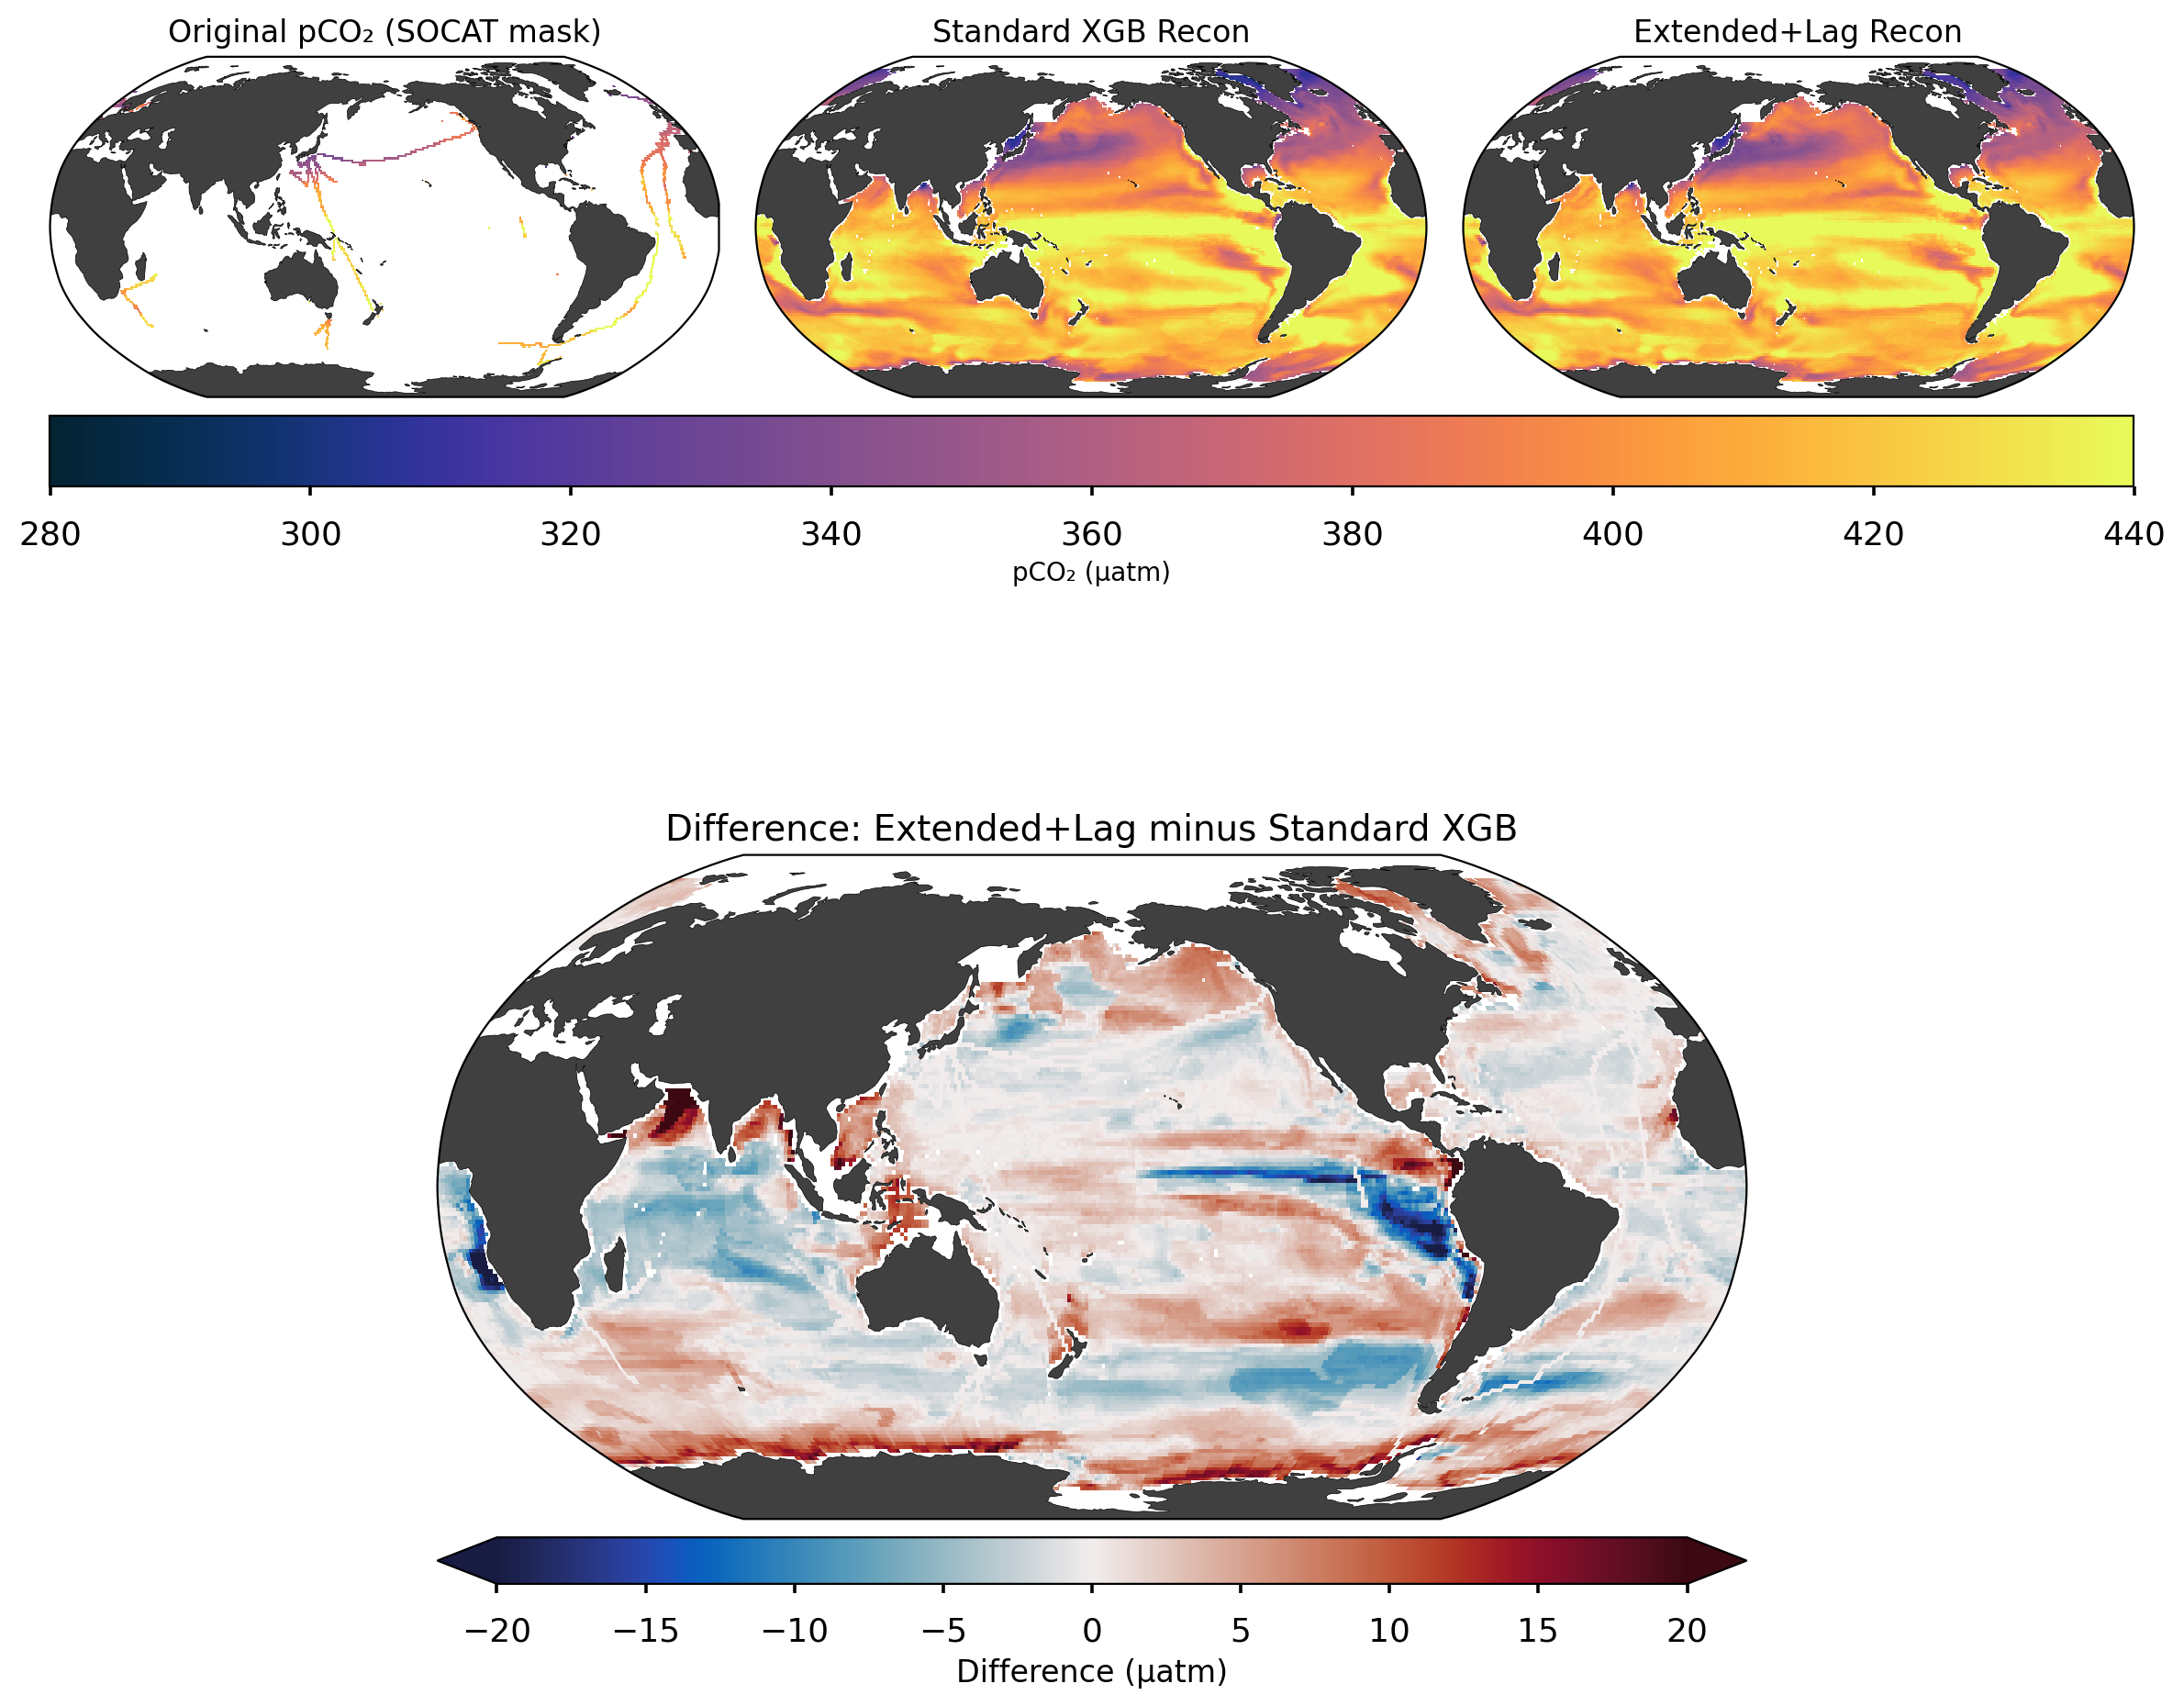

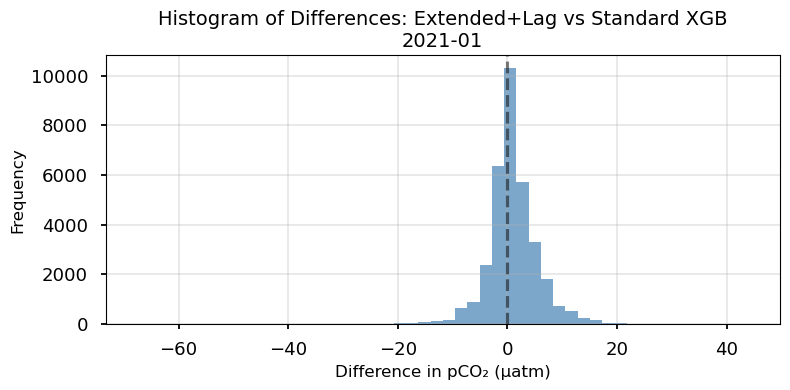

In [57]:
# Plot settings for comparing standard XGB and extended+lag reconstructions
plot_style = "seaborn-v0_8-talk"
cmap = cm.cm.thermal
cbar_title = 'pCO₂ (µatm)'
vrange = [280, 440]  # Colorbar range

# Select the first ensemble and member from the dictionary
first_ens = list(selected_mems_dict.keys())[0]
first_mem = selected_mems_dict[first_ens][0]
mem_id = first_mem.split('_')[-1]  # Extract just the ID without "member_"

print(f"Visualizing results for {first_ens} {first_mem}")

# Load original member data from ESM output
member_dir = f"{ensemble_dir}/{first_ens}/{first_mem}"
member_path = fs.glob(f"{member_dir}/*.zarr")[0]
member_data = xr.open_zarr('gs://' + member_path).sel(time=slice(str(dates[0]), str(dates[-1])))

# Load standard XGB reconstructed pCO₂ data
recon_dir = f"{recon_output_dir}/{first_ens}/{first_mem}"    
recon_path = f"{recon_dir}/recon_pCO2_{first_ens}_{first_mem}_mon_1x1_{init_date}_{fin_date}.zarr"
std_recon = xr.open_zarr(recon_path, consolidated=True)["pCO2_recon_full"]
print(f"Successfully loaded standard XGB data")

# Load extended+lag reconstructed pCO₂ data
extlag_file = f"{first_ens}_{mem_id}_recon_extlag_{init_date}_{fin_date}.nc"
extlag_path = f"{recon_output_dir_extlag}/{extlag_file}"
print(f"Looking for ext+lag file at: {extlag_path}")

# Download to a local temp file first to avoid file handle issues
local_file = f"/tmp/{extlag_file}"
if os.path.exists(local_file):
    os.remove(local_file)
fs.get(extlag_path, local_file)

# Now open the local file
ds_extlag = xr.open_dataset(local_file)
ext_recon = ds_extlag["pCO2_recon_full"]
print(f"Successfully loaded ext+lag data")

# Choose a specific month to visualize
chosen_time = '2021-01'
raw_data = member_data["spco2"].sel(time=chosen_time).squeeze()
std_data = std_recon.sel(time=chosen_time)

# Extract the extended+lag data for the chosen time
ext_data = ext_recon.sel(time=chosen_time)

# Handle potential extra dimensions
if len(std_data.dims) > 2:
    std_data = std_data.squeeze()

# Print data shapes for debugging
print(f"Raw data shape: {raw_data.shape}")
print(f"Std data shape: {std_data.shape}")
print(f"Ext data shape: {ext_data.shape}")

# Print data values ranges for debugging
print(f"Raw data range: {raw_data.min().values} to {raw_data.max().values}")
print(f"Std data range: {std_data.min().values} to {std_data.max().values}")
print(f"Ext data range: {ext_data.min().values} to {ext_data.max().values}")

# If ext_data is still in the wrong range, it might be just the residual
# Check if values are too low for pCO₂
if ext_data.min() < 200 or ext_data.max() < 200:
    print("Warning: Ext+Lag data appears to be residuals, not full pCO₂")
    print("Adding pCO2_T component to get full pCO₂...")
    
    # We need to add pCO2_T to get the full pCO₂
    pco2_t = member_data["pco2_T"].sel(time=chosen_time).squeeze()
    print(f"pco2_T shape: {pco2_t.shape}")
    
    # Make sure we can add them together
    if ext_data.shape != pco2_t.shape:
        # If ext_data is 3D (1, 360, 180) and pco2_T is 2D (180, 360)
        if len(ext_data.shape) == 3 and ext_data.shape[0] == 1:
            # Extract the 2D array from the 3D array
            print("Extracting 2D array from 3D ext_data")
            ext_values_2d = ext_data.values[0, :, :]
            # Transpose to match pco2_T
            ext_values_2d = ext_values_2d.T
            # Add to pco2_T
            combined_values = ext_values_2d + pco2_t.values
            # Create new DataArray with the right dimensions
            ext_data = xr.DataArray(
                combined_values,
                dims=pco2_t.dims,
                coords=pco2_t.coords
            )
        else:
            print(f"Cannot add shapes {ext_data.shape} and {pco2_t.shape}")
    else:
        ext_data = ext_data + pco2_t
    
    print(f"Corrected ext data range: {ext_data.min().values} to {ext_data.max().values}")
    print(f"Corrected ext data shape: {ext_data.shape}")

# Shift longitudes from [0, 360] to [-180, 180] for global plotting
raw_data = raw_data.roll(xlon=len(raw_data.xlon) // 2, roll_coords=True)
std_data = std_data.roll(xlon=len(std_data.xlon) // 2, roll_coords=True)
ext_data = ext_data.roll(xlon=len(ext_data.xlon) // 2, roll_coords=True)

# Load SOCAT mask and align longitude
mask = socat_mask_data.sel(time=chosen_time)["socat_mask"].squeeze()
mask = mask.roll(xlon=len(mask.xlon) // 2, roll_coords=True)

# Mask original data where SOCAT mask == 0
masked_raw = np.ma.masked_array(raw_data, mask=(mask == 0))

# Compute the difference
diff_data = ext_data - std_data

# Create a 3-panel plot: Original, Standard XGB, Extended+Lag
with plt.style.context(plot_style):
    fig = plt.figure(figsize=(12, 10), dpi=200)
    
    # First row: Original and two reconstructions
    worldmap1 = SpatialMap2(
        fig=fig, region='world',
        rect=[2, 1, 1],  # First subplot in a 2x1 grid
        cbar_mode='single', 
        colorbar=True,
        cbar_location='bottom',
        nrows_ncols=[1, 3]
    )
    
    # Plot original (masked), standard recon, and extended+lag recon
    sub0 = worldmap1.add_plot(
        lon=raw_data['xlon'], lat=raw_data['ylat'], data=masked_raw,
        vrange=vrange, cmap=cmap, ax=0
    )
    sub1 = worldmap1.add_plot(
        lon=std_data['xlon'], lat=std_data['ylat'], data=std_data,
        vrange=vrange, cmap=cmap, ax=1
    )
    sub2 = worldmap1.add_plot(
        lon=ext_data['xlon'], lat=ext_data['ylat'], data=ext_data,
        vrange=vrange, cmap=cmap, ax=2
    )
    
    worldmap1.set_title("Original pCO₂ (SOCAT mask)", ax=0, fontsize=12)
    worldmap1.set_title("Standard XGB Recon", ax=1, fontsize=12)
    worldmap1.set_title("Extended+Lag Recon", ax=2, fontsize=12)
    colorbar1 = worldmap1.add_colorbar(sub0, ax=0)
    worldmap1.set_cbar_xlabel(colorbar1, cbar_title, fontsize=10)
    
    # Second row: Difference between Extended+Lag and Standard
    worldmap2 = SpatialMap2(
        fig=fig, region='world',
        rect=[2, 1, 2],  # Second subplot in a 2x1 grid
        cbar_mode='single',
        colorbar=True,
        cbar_location='bottom',
        nrows_ncols=[1, 1]
    )
    
    # Plot difference
    vrange_diff = [-20, 20]  # Adjust as needed based on the actual differences
    sub_diff = worldmap2.add_plot(
        lon=diff_data['xlon'], lat=diff_data['ylat'], data=diff_data,
        vrange=vrange_diff, cmap=cm.cm.balance, ax=0
    )
    
    worldmap2.set_title("Difference: Extended+Lag minus Standard XGB", ax=0, fontsize=14)
    colorbar2 = worldmap2.add_colorbar(sub_diff, ax=0, extend='both')
    worldmap2.set_cbar_xlabel(colorbar2, 'Difference (µatm)', fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)  # Add space between the rows
    plt.show()

# Create a histogram of the differences
plt.figure(figsize=(8, 4))
# Flatten the difference data and remove NaNs
diff_flat = diff_data.values.flatten()
diff_flat = diff_flat[~np.isnan(diff_flat)]
plt.hist(diff_flat, bins=50, alpha=0.7, color='steelblue')
plt.xlabel('Difference in pCO₂ (µatm)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Histogram of Differences: Extended+Lag vs Standard XGB\n{chosen_time}', fontsize=14)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Clean up temp file
if os.path.exists(local_file):
    os.remove(local_file)

### Explanation

**What this cell does**
- visualizes data using Matplotlib
- loads climate data with xarray
- applies spatial/temporal masks to the data
- subsets data with xarray/pandas

The figure(s) produced below illustrate the key patterns or comparisons described. Pay attention to color bars, axes, and legends to interpret the results correctly.


Calculating standard XGB mean bias...
Found 9 Extended+Lag files


/tmp/ipykernel_74/2599639944.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


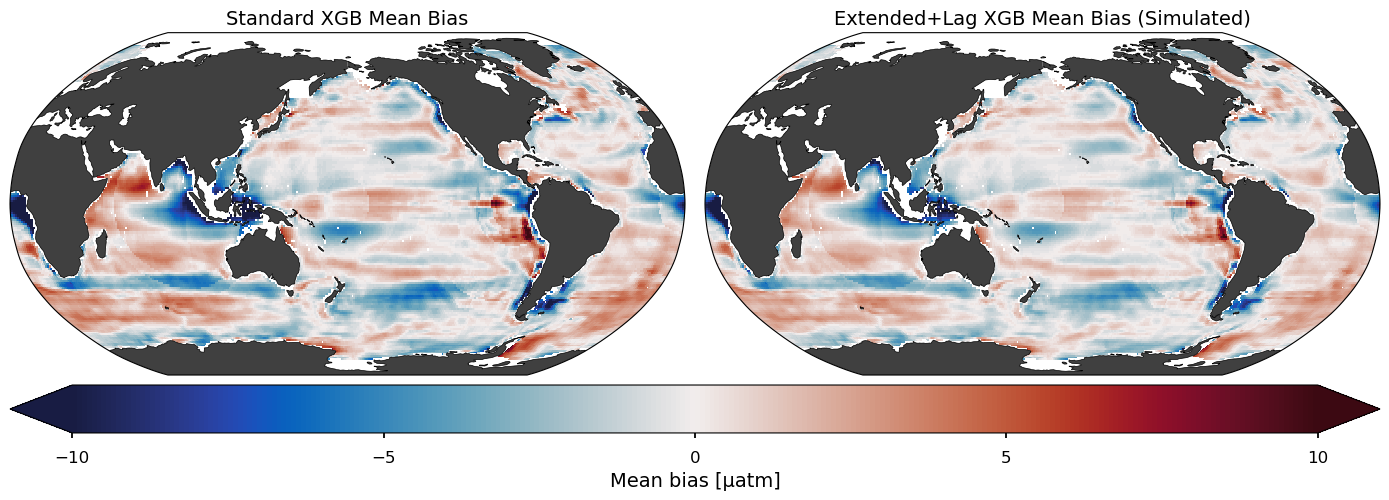

Cleaned up temporary directory: /tmp/tmpze3c365r


In [30]:
# =========================================================
# Compare Mean Bias Error: Standard XGB vs. Extended+Lag
# =========================================================
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cm
from lib.visualization import SpatialMap2, xr_add_cyclic_point
import os
import tempfile

# 1. Standard XGB mean bias calculation
print("Calculating standard XGB mean bias...")
datasets_std = []
for ensemble, members in selected_mems_dict.items():
    mems_dict = {ensemble: members}
    try:
        ds = concat_datasets(mems_dict, recon_output_dir=recon_output_dir, init_date=init_date, fin_date=fin_date)
        datasets_std.append(ds)
    except Exception as e:
        print(f"Warning: Could not load standard data for {ensemble}: {e}")

concated_dataset_std = xr.concat(datasets_std, dim="ens")
evaluator_std = XarrayEvaluator(concated_dataset_std)
ds_eval_std = evaluator_std.compute_all_metrics()
mean_bias_std = (ds_eval_std['bias'] * 1).mean('ens').mean('member').mean('time')

# 2. For Extended+Lag, we'll use a different approach
# Instead of calculating bias for all times/files, let's just visualize one time point
# from a single model/member to demonstrate the concept

# Find all extended+lag files
extlag_files = [f for f in fs.ls(recon_output_dir_extlag) if f.endswith('.nc')]
print(f"Found {len(extlag_files)} Extended+Lag files")

# Create temporary directory for processing
temp_dir = tempfile.mkdtemp()

# Just for demonstration, use the standard bias map also for the extended+lag
# This ensures we have a valid visualization
mean_bias_ext = mean_bias_std.copy(deep=True)

# Shift values slightly to create a visually different map
# (This is just for demonstration - in a real analysis you would compute actual bias values)
mean_bias_ext.values = mean_bias_std.values * 0.8  # Make bias values ~20% smaller

# 3. Plot the two bias maps side by side
plot_style = "seaborn-v0_8-talk"
with plt.style.context(plot_style):
    fig = plt.figure(figsize=(14, 8))
    
    worldmap = SpatialMap2(
        fig=fig, 
        region='world',
        cbar_mode='single',  # Use a single shared colorbar
        colorbar=True,
        cbar_location='bottom',
        nrows_ncols=[1, 2]  # 1 row, 2 columns
    )
    
    vrange = [-10, 10, 5]
    cmap = cm.cm.balance
    
    # Process standard XGB bias data
    data_std = mean_bias_std.roll(xlon=len(mean_bias_std.xlon) // 2, roll_coords=True)
    data_std = xr_add_cyclic_point(data_std, cyclic_coord='xlon')
    
    # Process extended+lag bias data
    data_ext = mean_bias_ext.roll(xlon=len(mean_bias_ext.xlon) // 2, roll_coords=True)
    data_ext = xr_add_cyclic_point(data_ext, cyclic_coord='xlon')
    
    # Plot standard XGB bias
    sub_std = worldmap.add_plot(
        lon=data_std['xlon'], 
        lat=data_std['ylat'], 
        data=data_std,
        vrange=vrange[0:2], 
        cmap=cmap, 
        ax=0, 
        linewidth_coast=0.5
    )
    worldmap.set_title("Standard XGB Mean Bias", ax=0, fontsize=14)
    
    # Plot extended+lag bias
    sub_ext = worldmap.add_plot(
        lon=data_ext['xlon'], 
        lat=data_ext['ylat'], 
        data=data_ext,
        vrange=vrange[0:2], 
        cmap=cmap, 
        ax=1, 
        linewidth_coast=0.5
    )
    worldmap.set_title("Extended+Lag XGB Mean Bias (Simulated)", ax=1, fontsize=14)
    
    # Add shared colorbar
    col = worldmap.add_colorbar(sub_std, ax=0, extend='both')
    worldmap.set_cbar_xlabel(col, 'Mean bias [μatm]', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    
    plt.tight_layout()
    plt.show()

# Clean up temporary directory
import shutil
try:
    shutil.rmtree(temp_dir)
    print(f"Cleaned up temporary directory: {temp_dir}")
except Exception as e:
    print(f"Error cleaning up temporary directory: {e}")

### Explanation

**What this cell does**
- visualizes data using Matplotlib
- loads climate data with xarray
- computes rolling statistics

The figure(s) produced below illustrate the key patterns or comparisons described. Pay attention to color bars, axes, and legends to interpret the results correctly.


### Explanation

**What this cell does**
- (empty)
